## Clustering and functional analysis on Bayesian timescales
Author: Robert Ietswaart  
Date: 20220301  
License: BSD2.  
Load modules j3dl and activate virtual environment using j4RNAdecay on O2.  
Python v3.7.4

Source: `Function_20211108.ipynb`  
For Subcellular Timelapse seq project. 

In [1]:
import os
import re
import copy
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
import logging
import argparse
import matplotlib.pyplot as plt
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
import seaborn as sns
from scipy.cluster import hierarchy
from scipy.stats import gmean, gstd
import new_total_ratio_jit as ntr
import fit

import urllib.request
from goatools.obo_parser import GODag
from goatools.base import download_ncbi_associations
from goatools.anno.genetogo_reader import Gene2GoReader
from goatools.goea.go_enrichment_ns import GOEnrichmentStudyNS

from scipy.stats import fisher_exact, chi2_contingency, mannwhitneyu

# from sklearn.cluster import AgglomerativeClustering

# from __init__ import __version__
from __init__ import default_logger_format, default_date_format

In [2]:
# def main():
np.random.seed(12345)

parser = argparse.ArgumentParser(
    description='Functional analysis of Bayes timescales.')

args = parser.parse_args("")#EDIT: added "" as argument to run in ipynb instead of .py script

In [3]:
path = os.path.join('/n','groups','churchman','ri23','bseq','Function20220301')

# Add a logger specific to the project and processing stage
logger = logging.getLogger('Function')
log_file = os.path.join(path,'LogErr', 'Functional_Analysis_20220301.log')
formatter = logging.Formatter(default_logger_format,
                              datefmt=default_date_format)
log_handler = logging.FileHandler(log_file)
log_handler.setFormatter(formatter)
logger.addHandler(log_handler)

organisms = ['m','h']
org_map = {'m': 'mouse', 'h': 'human'}
org_id_map = {'m': 10090, 'h': 9606}
fracs = ['chr', 'nuc', 'cyto', 'poly', 'tot']
reps = ['G','H','R','S','T','U']
red_reps = ['G_R', 'H_S', 'T', 'U']
# org_reps = {'m': ['G','H','R','S'], 'h': ['T', 'U']}
org_red_reps = {'m': ['G_R','H_S'], 'h': ['T', 'U']}
red_r = {'G': 'G_R', 'H': 'H_S', 'R': 'G_R', 'S': 'H_S', 'T': 'T', 'U': 'U'}
time_id = [str(i) for i in range(1,6)]
background_id = {r: '1' for r in reps}
time_mins = [0, 15, 30, 60, 120]
# T_bound_lo = 1e-4 #unit: min, ~6 ms
# T_bound_hi = 1e4 #unit: min, ~7 days

fracs_model = {'chr': ['chr_fit'],  
               'nuc': ['nuc_fit', 'nuc_fit_from_chr', 'nuc_fit_from_nucdeg'],
               'cyto': ['cyto_fit_from_nucres', 'cyto_fit_from_chr', 'cyto_fit_from_nucdeg'],
               'poly': ['poly_fit_from_nucres'],
               'tot': ['tot_fit', 'tot_pred_from_nucres', 'tot_pred_from_chr', 
                       'tot_fit_from_nucdeg', 'tot_pred_from_nucdeg']}

RATE_TYPE = ['half_life_','k_','T_']
rt = RATE_TYPE[0]
Timescales = ['chr',
              'nuc',
              'nucexp_from_chr',
              'nucdeg',
              'cyto',
              'poly_entry',
              'whole_cell',
              'nucexp_from_nucdeg']
Timescales = [rt + ts for ts in Timescales]

Timescales2fracs = {'T_chr': ['chr'],
                    'T_nuc': ['nuc'],
                    'T_nucexp_from_chr': ['chr','nuc'],
                    'T_nucexp_from_nucdeg': ['tot'],
                    'T_nucdeg' : ['nuc'],
                    'T_cyto' : ['cyto'],
                    'T_poly_entry' : ['poly'],
                    'T_whole_cell' : ['tot']}

frac_map = {fr: Timescales[i] for i,fr in enumerate(fracs)}
# frac_map_v2 = {fr: Timescales_v2[i] for i,fr in enumerate(fracs)}

# improved color code from 20211104
cmap={'chr':'#1D5386', 'nuc':'#506C23', 'cyto':'#B80000', 'poly':'#9E2E93', 'tot':'#D66B1F'}

TC_TYPES = ['top1000','bottom500']#BM model turnover method to estimate TC
# TC_from_jit = {1: 'top1000', 0: 'bottom500'}
OUT_TYPES = ['.Mean', '.MAP', '.0.975.quantile', '.0.025.quantile']


GS = dict()         #GRAND-SLAM
B = dict()          #Bayes fits file
K = dict()          #Bayes Factor
for o in organisms:  
    GS[o] = dict()   
    if o == 'm':
        path_gs = os.path.join('/n','groups','churchman','ri23','bseq','GS20210506')
        path_b = os.path.join('/n','groups','churchman','ri23','bseq','Bayes20220222')
        filename_b = 'Bayes20220228.tsv'   
    elif o == 'h':
        path_gs = os.path.join('/n','groups','churchman','ri23','bseq','GS20210713_human')
        path_b = os.path.join('/n','groups','churchman','ri23','bseq','Bayes20220228_human')
        filename_b = 'Bayes20220228_human.tsv'
    path_k = os.path.join('/n','groups','churchman','ri23','bseq','BayesFactor20220307')
    filename_k = 'Bayes_factor_20220315_' + org_map[o] + '.tsv'

    B[o] = pd.read_csv(os.path.join(path_b, filename_b), sep='\t')
    K[o] = pd.read_csv(os.path.join(path_k, filename_k), sep='\t')
    
    for r in reps:
        for fr in fracs:
            for tc in TC_TYPES:
                filename_gs = r + '_' + fr + '_noMT_' + tc + '.csv'
                if os.path.exists(os.path.join(path_gs, filename_gs)):
                    GS[o][red_r[r]+fr+tc]= pd.read_csv(os.path.join(path_gs, filename_gs) ,index_col=0)

### Clustering parameters: 
optimized for visualization and robustness of conclusions  
rt = half_life_, metric = seuclidean, N_clust = 50 (low/up bound controls 35 and 100), 
w Poly no MAP lower / upper cap 1e-1, 24h

In [4]:
Timescales_order = ['whole_cell',
                    'chr',
                    'nuc',
                    'cyto',
                    'poly_entry',
                    'nucexp_from_chr',
                    'nucdeg']

Timescales_v2_order =  Timescales_order
Timescales_v2_order = [ts.replace('_', ' ') for ts in Timescales_v2_order]
Timescales_order = [rt + ts for ts in Timescales_order]

In [5]:
clust_cols = dict()
vis_cols = dict()
idx_add = 5
for o in organisms:
    vis_cols[o] = []
    clust_cols[o] = []
    for ts in Timescales_order[:idx_add]:
        for ot in [OUT_TYPES[3], OUT_TYPES[1], OUT_TYPES[2]]:
            for rr in org_red_reps[o]:
                if not ts+ot == rt+'poly_entry'+OUT_TYPES[1]:#Poly are less reproducible: use only CI for clust
                    clust_cols[o].append(rr+'.'+ts+ot)

    vis_cols[o] = []
    for ts in Timescales[:(len(Timescales)-1)]:#different col order to match Brendan's Fig1
        for ot in [OUT_TYPES[3], OUT_TYPES[1], OUT_TYPES[2]]:
            for rr in org_red_reps[o]:
                vis_cols[o].append(rr+'.'+ts+ot)

clust_cols['h']

['T.half_life_whole_cell.0.025.quantile',
 'U.half_life_whole_cell.0.025.quantile',
 'T.half_life_whole_cell.MAP',
 'U.half_life_whole_cell.MAP',
 'T.half_life_whole_cell.0.975.quantile',
 'U.half_life_whole_cell.0.975.quantile',
 'T.half_life_chr.0.025.quantile',
 'U.half_life_chr.0.025.quantile',
 'T.half_life_chr.MAP',
 'U.half_life_chr.MAP',
 'T.half_life_chr.0.975.quantile',
 'U.half_life_chr.0.975.quantile',
 'T.half_life_nuc.0.025.quantile',
 'U.half_life_nuc.0.025.quantile',
 'T.half_life_nuc.MAP',
 'U.half_life_nuc.MAP',
 'T.half_life_nuc.0.975.quantile',
 'U.half_life_nuc.0.975.quantile',
 'T.half_life_cyto.0.025.quantile',
 'U.half_life_cyto.0.025.quantile',
 'T.half_life_cyto.MAP',
 'U.half_life_cyto.MAP',
 'T.half_life_cyto.0.975.quantile',
 'U.half_life_cyto.0.975.quantile',
 'T.half_life_poly_entry.0.025.quantile',
 'U.half_life_poly_entry.0.025.quantile',
 'T.half_life_poly_entry.0.975.quantile',
 'U.half_life_poly_entry.0.975.quantile']

In [6]:
## Prefilter timescales for NA data
T_bf = 100

C = copy.deepcopy(B)
for o in organisms:
    C[o] = C[o].merge(K[o], on='Gene', suffixes=('', '_bf'))
    logger.info('%s all genes: %d' % (org_map[o], len(C[o])))
    C[o] = C[o][~C[o][clust_cols[o]].isna().any(axis=1)]
    logger.info('%s genes without NA timescales: %d' % (org_map[o], len(C[o])))
    
    
    for ts in Timescales_order:
        for ot in OUT_TYPES:
            for rr in org_red_reps[o]:
                if ts == rt+'nucexp_from_chr':#only for nucres genes according to Bayes Factor
                    C[o][rr+'.'+ts+ot].where(C[o][rr+'.bayes_factor'] <= T_bf, 
                                              C[o][rr+'.'+rt+'nucexp_from_nucdeg'+ot], inplace=True)                        
                if ts == rt+'nucdeg':#only for nucdeg genes according to Bayes Factor
                    C[o][rr+'.'+ts+ot].where(C[o][rr+'.bayes_factor'] > T_bf, (24*60), inplace=True)
             

                ###Clip range of values beyond realistic timescale values: 0.1min and 24h 
                #do not clip 1 fraction: not good for robustness of clustering: avoid or clip all fractions
                C[o][rr+'.'+ts+ot].where(C[o][rr+'.'+ts+ot] > 1e-1, 1e-1, inplace=True) 
                C[o][rr+'.'+ts+ot].where(C[o][rr+'.'+ts+ot] < (24*60), (24*60), inplace=True)                  


INFO: [2022-06-15 12:26:08] Function - mouse all genes: 17332
INFO: [2022-06-15 12:26:09] Function - mouse genes without NA timescales: 10918
INFO: [2022-06-15 12:26:09] Function - human all genes: 17908
INFO: [2022-06-15 12:26:09] Function - human genes without NA timescales: 10875


## Hierarchical clustering in Python:
and NOT USED heatmap visualization. See below for R visualization.  
https://stackoverflow.com/questions/27924813/extracting-clusters-from-seaborn-clustermap

https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.fcluster.html#scipy.cluster.hierarchy.fcluster

INFO: [2022-06-15 12:26:10] Function - start hierarchical clustering h
INFO: [2022-06-15 12:26:39] Function - end hierarchical clustering h


<Figure size 432x288 with 0 Axes>

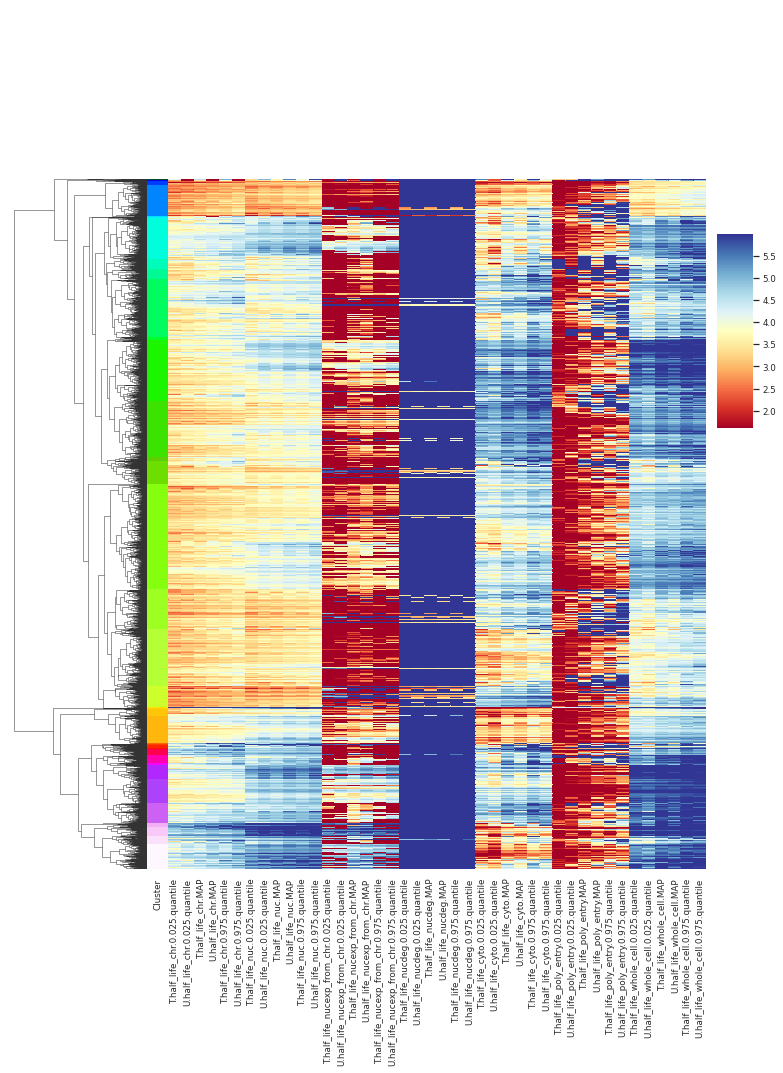

In [7]:
g = dict()
row_link = dict()

N_clust = 50 ######################50, 35 (lower bound control), 100 (upper bound control)
clust = dict()
for o in organisms[1:]:
    logger.info('start hierarchical clustering %s' % o)
    row_link[o] = hierarchy.linkage(np.log(C[o][clust_cols[o]]), 
                                    metric ='seuclidean', #metric ='correlation' = not good
                                    method='complete',#default:'complete',
                                    optimal_ordering=False)#True: takes a long time and does not help
    clust[o] = hierarchy.fcluster(row_link[o], t=N_clust, criterion='maxclust')
    C[o].insert(loc=1, column='Cluster', value=clust[o])
    
    
    #prep for colored clusters 
    clust_cmap = dict()
    temp_cmap = plt.get_cmap('gist_ncar', N_clust) 
    #'Paired' 'tab20b' is name of colormap, you need to choose a continuous one 
    #https://matplotlib.org/stable/tutorials/colors/colormaps.html
    for i in range(1,(N_clust+1)):
        clust_cmap[i] = temp_cmap(i-1) 
    row_colors = C[o]['Cluster'].map(clust_cmap) 
    
    #plot
    fig1 = plt.figure()
    sns.set(style="whitegrid", color_codes=True,font_scale=0.8)
    g[o] = sns.clustermap(np.log(C[o][vis_cols[o]]), row_linkage=row_link[o], 
                          cmap='RdYlBu', vmin=np.log(5), vmax=np.log(400), #cmap='PuOr','RdBu','inferno','bwr'
                          cbar_pos=(1, 0.6, 0.05, 0.18), row_colors=row_colors, 
#                           metric ='correlation', method='complete', #already specified with row_link
                          figsize=(10,15), col_cluster=False, yticklabels=False)
    
    filename = 'Cluster_timescales_' + o
#     plt.savefig(os.path.join(path, filename + '.pdf'), bbox_inches="tight", transparent=True)
    # plt.savefig(os.path.join(path, filename + '.png'), bbox_inches="tight", transparent=True)

#     ### Write clustered data to file
#     C[o].iloc[g[o].dendrogram_row.reordered_ind,:].to_csv(os.path.join(path, filename+'.csv'), 
#                                                           sep='\t',index=False, header=True)

    logger.info('end hierarchical clustering %s' % o)

# Visualization of clusters

In [8]:
o='h' #'m' #
centroid = dict()
centroid['compartment'] = Timescales_order
N_ok_clust = 0
ok_clust = []
for i in range(1,(N_clust+1)):
    df = C[o][C[o]['Cluster']==i]
    for rr in org_red_reps[o]:
        centroid[str(i)+rr+'median'] = []
        centroid[str(i)+rr+'ci_lo'] = []
        centroid[str(i)+rr+'ci_hi'] = []
        for ts in Timescales_order:
            ci_lo = df[rr+'.'+ts+OUT_TYPES[3]].median()
            ci_hi = df[rr+'.'+ts+OUT_TYPES[2]].median()
            centroid[str(i)+rr+'ci_lo'].append(ci_lo)
            centroid[str(i)+rr+'ci_hi'].append(ci_hi)
            centroid[str(i)+rr+'median'].append(df[rr+'.'+ts+OUT_TYPES[1]].median())

#Determine OK clusters: reproducible and  size > 1
r1 = org_red_reps[o][0]
r2 = org_red_reps[o][1]
for i in range(1,(N_clust+1)):
    bool_ok_clust = True
    if len(C[o][C[o]['Cluster']==i])==1:
        bool_ok_clust = False
    for j, ts in enumerate(Timescales_order[:idx_add]):
        #if not reproducible: more than 4x difference between replicates
        if abs(np.log(centroid[str(i)+r1+'median'][j]) -  np.log(centroid[str(i)+r2+'median'][j])) > np.log(4):
            bool_ok_clust = False
    if bool_ok_clust:
        N_ok_clust += 1
        ok_clust.append(i)
        
centroid = pd.DataFrame(centroid)
logger.info('Reproducible clusters with size > 1: %d / %d ' % (N_ok_clust, N_clust))

INFO: [2022-06-15 12:26:45] Function - Reproducible clusters with size > 1: 27 / 50 


cluster: 7 N_genes=70
cluster: 8 N_genes=482
cluster: 12 N_genes=642
cluster: 15 N_genes=917
cluster: 17 N_genes=959
cluster: 18 N_genes=873
cluster: 19 N_genes=69
cluster: 20 N_genes=360
cluster: 22 N_genes=1662
cluster: 23 N_genes=636
cluster: 24 N_genes=896
cluster: 25 N_genes=329
cluster: 28 N_genes=4
cluster: 30 N_genes=12
cluster: 31 N_genes=110
cluster: 32 N_genes=435
cluster: 35 N_genes=18
cluster: 37 N_genes=15
cluster: 38 N_genes=98
cluster: 39 N_genes=119
cluster: 42 N_genes=228
cluster: 43 N_genes=373
cluster: 44 N_genes=316


/n/groups/churchman/ri23/code/RNAdecayenv/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


cluster: 47 N_genes=53
cluster: 48 N_genes=140
cluster: 49 N_genes=137
cluster: 50 N_genes=373


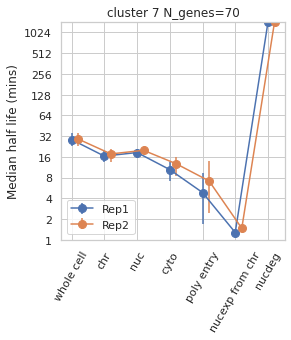

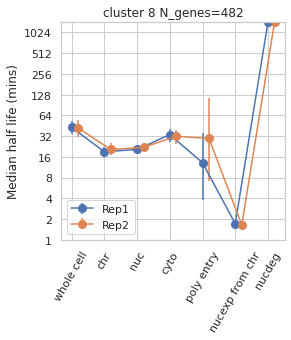

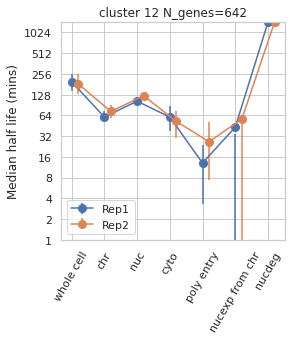

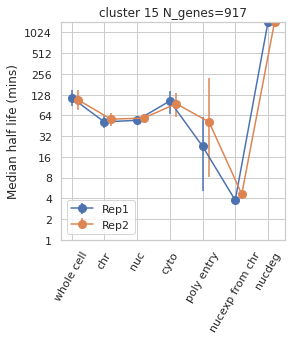

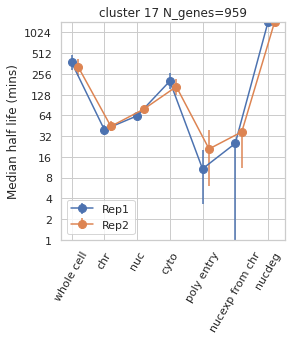

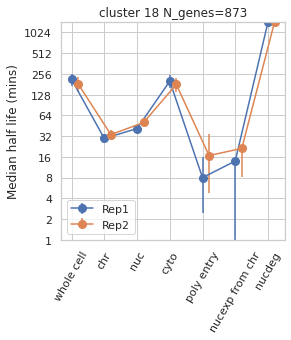

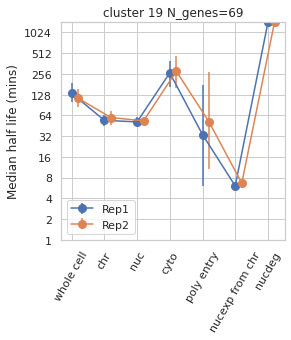

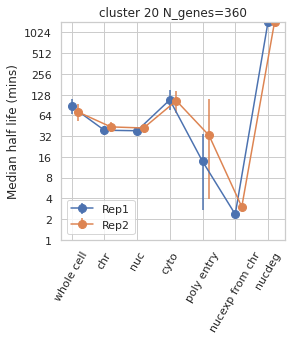

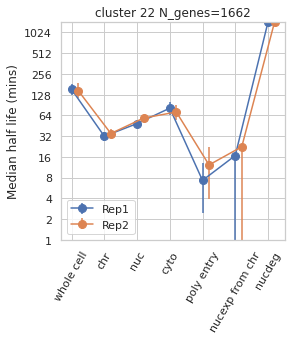

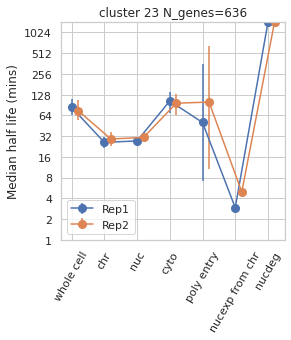

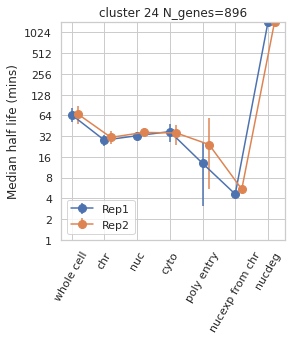

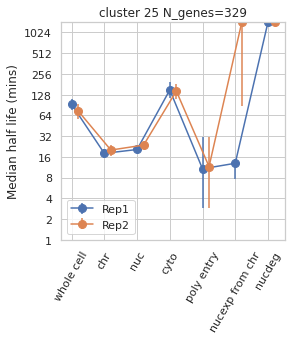

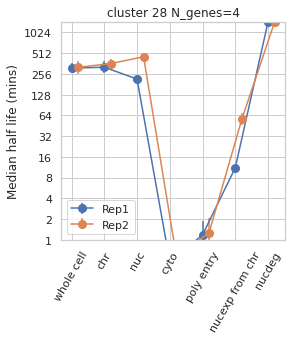

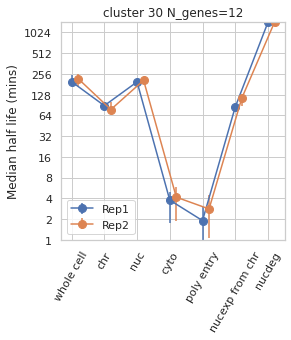

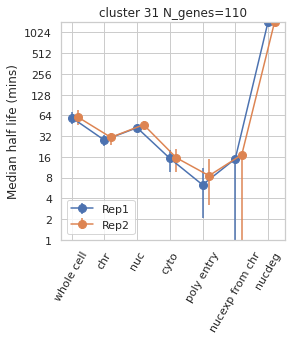

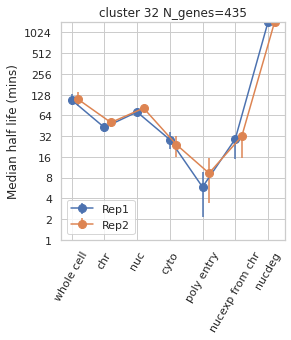

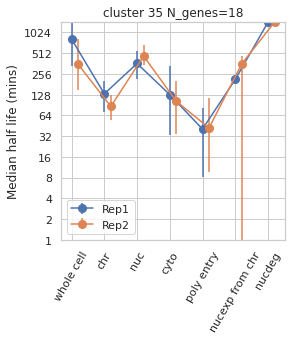

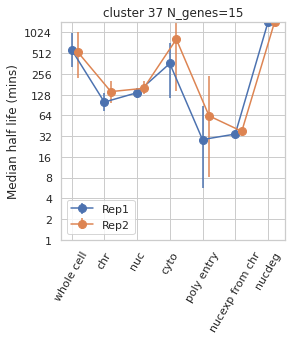

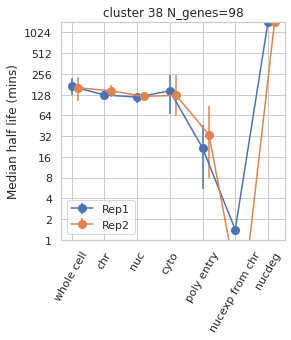

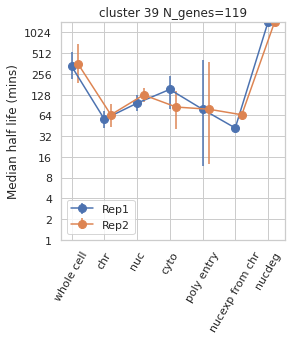

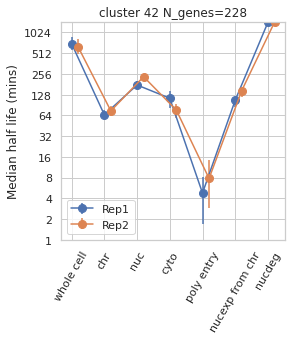

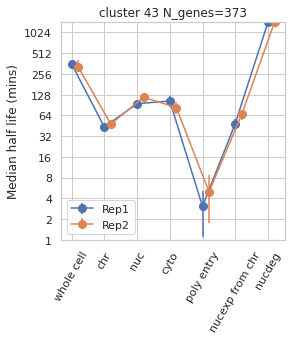

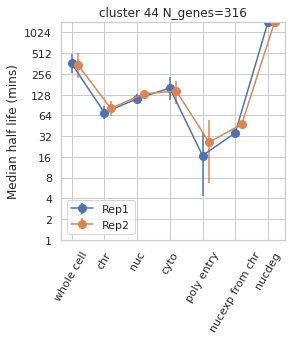

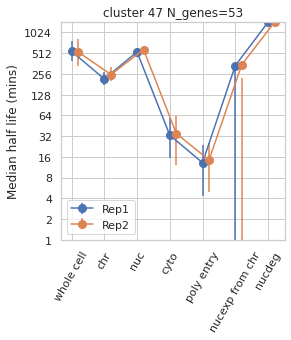

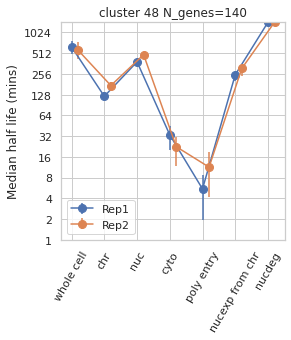

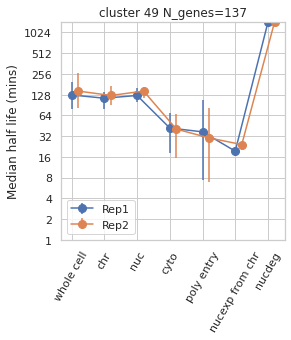

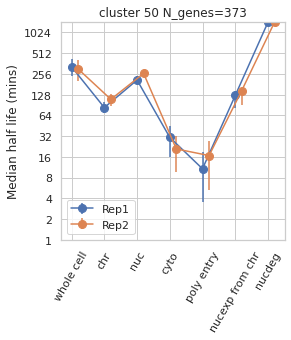

In [42]:
x_clust = np.arange(len(Timescales_order))#the label locations

for i in range(1,(N_clust+1)):
    if i in ok_clust:
        print('cluster: '+str(i)+' N_genes='+str(len(C[o][C[o]['Cluster']==i])))
        sns.set(style="whitegrid", color_codes=True,font_scale=1)
        f, ax = plt.subplots(figsize=(4, 4))   
        leg = []
        for j, rr in enumerate(org_red_reps[o]):
            ax.errorbar(x=x_clust+(0.2*j), y=centroid[str(i)+rr+'median'],
                        yerr=[centroid[str(i)+rr+'median'] - centroid[str(i)+rr+'ci_lo'],
                              centroid[str(i)+rr+'ci_hi'] - centroid[str(i)+rr+'median']], 
                        fmt='-o', ms=8) 
        plt.ylabel('Median %s(mins)' % rt.replace('_',' '))
        plt.xticks(x_clust, Timescales_v2_order, rotation = 60,) #[:idx_add]
        ax.set(yscale="log")
        plt.yticks([2**j for j in range(11)], [2**j for j in range(11)])
        plt.ylim([1, 24*60])
        plt.title('cluster '+str(i)+' N_genes='+str(len(C[o][C[o]['Cluster']==i])))
        ax.legend(['Rep1','Rep2'], loc='lower left')#, bbox_to_anchor=(1, 0.3))

        filename = 'Cluster_medians_' + o + '_' + str(i)
        #     plt.savefig(os.path.join(path, filename + '.pdf'), bbox_inches="tight", transparent=True)
        #     # plt.savefig(os.path.join(path, filename + '.png'), bbox_inches="tight", transparent=True)

## Use R to visualize reordered and (ok) filtered clustered heatmap
run first the `Visualization of clusters` section to get the reproducible ok_clusters

https://anderfernandez.com/en/blog/how-to-program-with-python-and-r-in-the-same-jupyter-notebook/

hclust https://www.rdocumentation.org/packages/stats/versions/3.6.2/topics/hclust

sharing variables across R and Python in jupyter notebook: https://stackoverflow.com/questions/55841165/share-variables-between-r-and-python-in-jupyternotebook

In [3]:
%load_ext rpy2.ipython

In [4]:
%%R
library(pheatmap)
library(ggplot2)
library(RColorBrewer)

In [19]:
%R -i path
%R -i rt
%R -i o
%R -i N_clust
%R -i N_ok_clust

In [20]:
o = 'h'

#dr: dataframe used for clustering in R and for reordering dendogram
dr = copy.deepcopy(C[o])
%R cc <- c()
for c in clust_cols[o]:
    dr['s'+c] = np.log(dr[c])
    dr['s'+c] = dr['s'+c] / dr['s'+c].std()
    %R -i c
    %R cc <- append(cc, paste0('s',c))

#filter for ok clustered genes:    
for i in C[o]['Cluster'].unique():
    cid = C[o][C[o]['Cluster']==i].index
    if i not in ok_clust:
        dr.drop(index=cid, inplace=True)
        
#get weights for reordering of dendogram based on short to long half lives
ot1 = OUT_TYPES[1]
for ts in Timescales_order[:idx_add]:
    dr[ts+ot1] = 0
    for rr in org_red_reps[o]:
        dr[ts+ot1] += dr[rr+'.'+ts+ot1]
    dr[ts+ot1] = dr[ts+ot1] / len(org_red_reps[o])

#sort by short to long half lives for whole cell, then chrom etc
sort_order = [ts+ot1 for ts in Timescales_order[:idx_add]]
sort_ascent = [True for ts in Timescales_order[:idx_add]]
# sort_order.insert(1,'Cluster')
# sort_ascent.insert(1,False)
dr.sort_values(by=sort_order, ascending=sort_ascent, inplace=True)
#append dendogram reorder weights: current sorted ranking
dr['dend_weight'] = pd.DataFrame(range(1,len(dr)+1), columns=['dend_weight'], index=dr.index)
dr.sort_index(inplace=True)#sort back to original
%R -i dr
   
#get dplot, the dataframe for heatmap visualization in R: with log(half lives) 
dplot = pd.DataFrame(index=C[o].index)
%R vc <- c() #vis_cols in R
for c in vis_cols[o]:
    dplot[c] = np.log(C[o][c])
    %R vc <- append(vc, c)

#filter for ok clustered genes:     
for i in C[o]['Cluster'].unique():
    cid = C[o][C[o]['Cluster']==i].index
    if i not in ok_clust:
        dplot.drop(index=cid, inplace=True)
    
%R -i dplot

### R hierarchical clustering with reordering

In [21]:
%%R
#get hierarchical clustering
dm = as.matrix(dr[cc]) #it is just a matrix, already checked.
hc <- hclust(dist(dm, method = "euclidean"), method = "complete")

#reorder dendogram 
dend = reorder(as.dendrogram(hc), wts = dr$dend_weight, agglo.FUN = mean)#sum instead of mean does not work
hc_order = as.hclust(dend)

In [47]:
# %%R
# plot(hc) #plots a dendrogram: for visual check

In [48]:
# %%R
# plot(hc_order)

## R pheatmap visualization

pheatmap https://www.rdocumentation.org/packages/pheatmap/versions/1.0.12/topics/pheatmap

customize the visualization:
https://stackoverflow.com/questions/41628450/r-pheatmap-change-annotation-colors-and-prevent-graphics-window-from-popping-up

retrieve cluster information from dendogram https://www.biostars.org/p/86563/  

Color palettes
https://colorspace.r-forge.r-project.org/articles/hcl_palettes.html

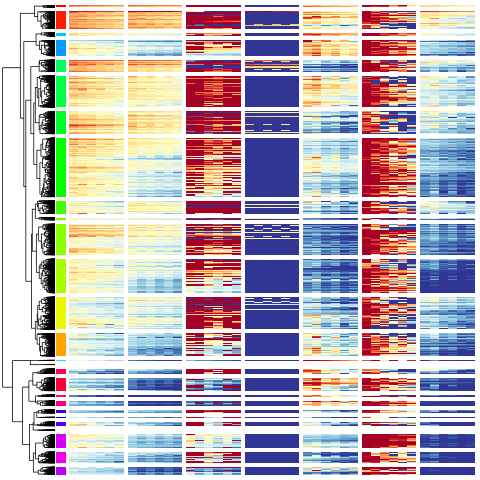

In [22]:
%%R

# Set colorscale: the minimum, the maximum, and the increasing steps (0.04) for the color scale
hlcol_min = 5
hlcol_max = 300
breaksList = seq(log(hlcol_min), log(hlcol_max), by = 0.04)
# Cluster annotation colormap
anno_cmap = colorRampPalette(grDevices::rainbow(N_ok_clust)) 
#too pastel: hcl.colors(n = N_clust, palette = 'Dark3'))##too pastel: brewer.pal(n = 11, name = 'Spectral'))##
anno_colors <- anno_cmap(N_ok_clust)
names(anno_colors) <- unique(dr$Cluster)
anno_colors <- list(Cluster=anno_colors)

filename = paste0('Cluster_R_',rt,o,'.pdf')

#plot final heatmap
ph <- pheatmap(dplot, 
         cluster_rows = hc_order, 
         cluster_cols = FALSE,
         color = colorRampPalette(brewer.pal(n = 11, name = 'RdYlBu'))(length(breaksList)),
#NOT USE# color = colorRampPalette(rev(hcl.colors(n = length(breaksList), palette = "Zissou 1")))(length(breaksList)),
#NOT USE#'ArmyRose''TealRose' 
         breaks = breaksList,
         border_color = NA,
         show_rownames = FALSE,
         show_colnames = FALSE,
         annotation_row = dr['Cluster'],
         annotation_colors = anno_colors,
         annotation_names_row = FALSE,
#          gaps_row=c(),#does not work when rows are clustered: instead use cutree_rows
         gaps_col=c(6,12,18,24,30,36),
         cutree_rows = N_ok_clust,#N_clust,##gives spaces between clusters
         annotation_legend = FALSE,
         legend=FALSE,#####Set to TRUE for legend
         legend_breaks = c(log(hlcol_min), log(7.5), log(15), log(30), log(60), 
                           log(120), log(240), log(hlcol_max)),
         legend_labels = c(hlcol_min, 7.5, 15, 30, 60, 120, 240, hlcol_max),
#          row_split = 2,# does not work
#          cellheight = 6,#autoscale is much better...
#          cellwidth = 20,#not used
#          fontsize_col = 6,#not used
#          main="Genes clustered by RNA flow half lives",#title, not used
               
#          filename = paste0(path,"/",filename), #############################   UNCOMMENT TO SAVE AS PDF #
         width = 10, height = 20)#does not work in jupyter visualization, only for pdf


## Get clustering numbers from R into Python

In [23]:
%%R
#get the R cluster numbers for all gene indexes in original order
orcl <- cutree(hc_order, k=N_ok_clust)

# add the R cluster numbers to your data
dr_fromR <- cbind(dr, ClusterR=orcl)

#reorder data to match the order in the heatmap:
dr_fromR <- dr_fromR[hc_order$order,]

#get heatmap color map to Python
anno_colors <- anno_cmap(N_ok_clust)

In [24]:
# examine the R cluster numbers by order in the R heatmap
%R clusterR_order_heatmap = unique(orcl[hc_order$order])

#pass it to Python
%R -o clusterR_order_heatmap 
%R -o dr_fromR 
%R -o anno_colors

In [25]:
map_cl_R2Py = dict()
map_cl_Py2R = dict()
map_cl_R2Heatmaprank = dict()

for i, clR in enumerate(dr_fromR['ClusterR'].unique()):
    clPy = dr_fromR['Cluster'].unique()[i]
    map_cl_R2Py[clR] = clPy
    map_cl_Py2R[clPy] = clR
    map_cl_R2Heatmaprank[clR] = i+1

In [87]:
for cl in range(N_clust):
    if cl in map_cl_Py2R.keys():
        logger.info(['py:',cl,
          'R cluster:', map_cl_Py2R[cl], 
          'rank heatmap:', clusterR_order_heatmap.tolist().index(map_cl_Py2R[cl])+1 ])

INFO: [2022-06-15 16:09:56] Function - ['py:', 7, 'R cluster:', 20, 'rank heatmap:', 1]
INFO: [2022-06-15 16:09:56] Function - ['py:', 8, 'R cluster:', 2, 'rank heatmap:', 2]
INFO: [2022-06-15 16:09:56] Function - ['py:', 12, 'R cluster:', 9, 'rank heatmap:', 14]
INFO: [2022-06-15 16:09:56] Function - ['py:', 15, 'R cluster:', 3, 'rank heatmap:', 13]
INFO: [2022-06-15 16:09:56] Function - ['py:', 17, 'R cluster:', 1, 'rank heatmap:', 12]
INFO: [2022-06-15 16:09:56] Function - ['py:', 18, 'R cluster:', 10, 'rank heatmap:', 11]
INFO: [2022-06-15 16:09:56] Function - ['py:', 19, 'R cluster:', 24, 'rank heatmap:', 10]
INFO: [2022-06-15 16:09:56] Function - ['py:', 20, 'R cluster:', 19, 'rank heatmap:', 9]
INFO: [2022-06-15 16:09:56] Function - ['py:', 22, 'R cluster:', 8, 'rank heatmap:', 8]
INFO: [2022-06-15 16:09:56] Function - ['py:', 23, 'R cluster:', 6, 'rank heatmap:', 7]
INFO: [2022-06-15 16:09:56] Function - ['py:', 24, 'R cluster:', 14, 'rank heatmap:', 6]
INFO: [2022-06-15 16:09:

### Write hierarchically clustered data to file

In [52]:
dr_fromR['Cluster_heatmap'] = dr_fromR['ClusterR'].map(map_cl_R2Heatmaprank)
dr_fromR.drop(['Cluster','ClusterR'], axis=1, inplace=True)

filename = 'Cluster_R_'+rt+o+'.tsv'
# dr_fromR.to_csv(os.path.join(path, filename), sep='\t')

### Manuscript statistics

In [ ]:
cl_py = 22 #cluster 22 in py = cluster 8 in heatmap: largest cluster
cl_heat = clusterR_order_heatmap.tolist().index(map_cl_Py2R[cl_py])+1
N_cl8_genes = len(dr_fromR[dr_fromR['Cluster_heatmap']==cl_heat])
N_notcl8_genes =len(dr_fromR)-len(dr_fromR[dr_fromR['Cluster_heatmap']==cl_heat])
logger.info(' gene cluster %d: %d, other genes: %d' % (cl_heat, N_cl8_genes, N_notcl8_genes))
rr = 'T'
logger.info(centroid[str(cl_py)+rr+'median'][0])#whole cell: [0]
rr = 'U'
logger.info(centroid[str(cl_py)+rr+'median'][0])

# GO enrichment analysis with GOAtools

source: https://github.com/tanghaibao/goatools/blob/main/notebooks/goea_nbt3102.ipynb

#in terminal in `O2/GO/bseq` folder only once:
#wget http://purl.obolibrary.org/obo/go.obo
#wget ftp://ftp.ncbi.nlm.nih.gov/gene/DATA/gene2go.gz

In [13]:
#Load GO OBO and (human) gene annotations
path_go_obo = os.path.join('/n','groups','churchman','ri23','GO','bseq')
filename = 'go.obo'
go_dag = GODag(os.path.join(path_go_obo,filename))

#load human annotation files
filename = 'gene2go'
filename_gene2go = download_ncbi_associations(gene2go=os.path.join(path_go_obo,filename))

objanno = dict()
ns2assoc = dict()
for o in organisms: 
    logger.info(o)
    # Read NCBI's gene2go. Store annotations in a list of namedtuples
    objanno[o] = Gene2GoReader(filename_gene2go, taxids=[org_id_map[o]])

    # Get namespace2association where:
    #    namespace is:
    #        BP: biological_process               
    #        MF: molecular_function
    #        CC: cellular_component
    #    assocation is a dict:
    #        key: NCBI (Entrez) GeneID
    #        value: A set of GO IDs associated with that gene

    ns2assoc[o] = objanno[o].get_ns2assc()
    
    for nspc, id2gos in ns2assoc[o].items():
        logger.info("{NS} {N:,} annotated genes".format(NS=nspc, N=len(id2gos)))

/n/groups/churchman/ri23/GO/bseq/go.obo: fmt(1.2) rel(2021-12-15) 47,157 GO Terms
  EXISTS: /n/groups/churchman/ri23/GO/bseq/gene2go


INFO: [2022-06-15 12:45:19] Function - m


HMS:0:00:22.030577 419,975 annotations, 29,776 genes, 18,911 GOs, 1 taxids READ: /n/groups/churchman/ri23/GO/bseq/gene2go 


INFO: [2022-06-15 12:45:44] Function - h


CC 19,352 annotated genes
MF 17,429 annotated genes
BP 18,633 annotated genes
HMS:0:00:20.434301 335,439 annotations, 20,702 genes, 18,739 GOs, 1 taxids READ: /n/groups/churchman/ri23/GO/bseq/gene2go 
CC 19,473 annotated genes
MF 18,227 annotated genes
BP 18,569 annotated genes


In [50]:
###get gene_mapper file so that you can map ENSG to Entrez gene IDs used for GO enrichment analysis
def get_hgnc(resource_folder):
    fname = os.path.join(resource_folder, 'hgnc_entries.tsv')
    if not os.path.exists(fname):
        # Select relevant columns and parameters
        cols = ['gd_hgnc_id', 'gd_app_sym', 'gd_app_name', 'gd_prev_sym',
                'gd_status', 'md_eg_id', 'md_prot_id', 'md_mgd_id',
                'md_rgd_id', 'gd_pub_ensembl_id']
        statuses = ['Approved', 'Entry%20Withdrawn']
        params = {
            'hgnc_dbtag': 'on',
            'order_by': 'gd_app_sym_sort',
            'format': 'text',
            'submit': 'submit'
        }

        # Construct a download URL from the above parameters
        url = 'https://www.genenames.org/cgi-bin/download/custom?'
        url += '&'.join(['col=%s' % c for c in cols]) + '&'
        url += '&'.join(['status=%s' % s for s in statuses]) + '&'
        url += '&'.join(['%s=%s' % (k, v) for k, v in params.items()])

        # Save the download into a file
        urllib.request.urlretrieve(url, fname)
    return fname

gene_map = dict()

#Human
filename_hgnc = get_hgnc(path_go_obo)
gene_map['h'] = pd.read_csv(filename_hgnc, sep='\t')
col_map = {'HGNC ID': 'hgnc_id',
           'Approved symbol': 'Symbol',
           'Previous symbols': 'old_symbol',
           'NCBI Gene ID(supplied by NCBI)': 'entrez_id',
           'UniProt ID(supplied by UniProt)':'up_id',
           'Mouse genome database ID(supplied by MGI': 'mgi_id',
           'Rat genome database ID(supplied by RGD)': 'rgd_id',
           'Ensembl gene ID': 'ens_id'}
gene_map['h'].rename(mapper=col_map, axis=1, inplace=True) 

#Mouse
filename_hgnc = os.path.join('/n','groups','churchman','ri23','GO','bseq','Mouse_ens_entrez_map.csv')
gene_map['m'] = pd.read_csv(filename_hgnc, sep=',',dtype={'entrezgene_id': str})
col_map = {'ensembl_gene_id':'ens_id',
           'mgi_symbol':'Symbol',
           'entrezgene_id':'entrez_id'}
gene_map['m'].rename(mapper=col_map, axis=1, inplace=True) 
gene_map['m'] = gene_map['m'][~gene_map['m']['entrez_id'].isna()]

In [15]:
o = 'h'

#Get universe of genes (entrez_ids) for enrichment analysis
gene_universe = list(gene_map[o][gene_map[o]['ens_id'].isin(C[o]['Gene'])]['entrez_id'].astype(int))

alpha_fdr = 0.05 / N_ok_clust ##/ N_clust #

#Initialize a GOEA object
goeaobj = GOEnrichmentStudyNS(gene_universe, # universe List of protein-coding genes
                              ns2assoc[o], #geneid/GO associations (from NCBI gene)
                              go_dag, # Ontologies
                              propagate_counts = True,#default True: parental GOannos are also annotations 
                              alpha = alpha_fdr, # default significance cut-off
                              methods = ['fdr_bh']) # default multiple test correction method


Load BP Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
Propagating term counts 

4 GO IDs NOT FOUND IN ASSOCIATION: GO:2001216 GO:0036404 GO:0033168 GO:0001207


up: is_a
 90%  9,506 of 10,560 population items found in association

Load CC Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
Propagating term counts up: is_a
 95%  9,990 of 10,560 population items found in association

Load MF Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
Propagating term counts up: is_a


1 GO IDs NOT FOUND IN ASSOCIATION: GO:0031493


 94%  9,878 of 10,560 population items found in association


## Run enrichment analysis

'p_' means "pvalue". 'fdr_bh' is the multipletest method we are currently using.  
"e" in the "Enrichment" column means "enriched" - the concentration of GO term in the study group is significantly higher than those in the population.  
"p" stands for "purified" - significantly lower concentration of the GO term in the study group than in the population.
https://github.com/tanghaibao/goatools

To get the genes corresponding to an enriched GO term, see GOEnrichmentRecord object description:
https://github.com/tanghaibao/goatools/blob/main/goatools/go_enrichment.py

GOEnrichmentRecord.study_items = annotated genes in NCBI IDs

In [26]:
#Run enrichment analysis

goea_results_all = dict()

# for cl in range(1,(N_clust+1)):#using Python cluster ordering: see bottom script for that code version.
#     if cl in ok_clust:
for cl_rank_heatmap, cl in enumerate(clusterR_order_heatmap):
    
    logger.info('rank %d cluster R heatmap: %d (py:%d)' % ((cl_rank_heatmap+1), cl, map_cl_R2Py[cl]))

    cluster_genes = C[o][C[o]['Cluster']==map_cl_R2Py[cl]]['Gene']
    logger.info('N_genes in cluster: %d' % len(cluster_genes))
    logger.info(list(gene_map[o][gene_map[o]['ens_id'].isin(cluster_genes)].sort_values(by='Symbol')['Symbol']))
    geneids_study = list(gene_map[gene_map[o]['ens_id'].isin(cluster_genes)]['entrez_id'].astype(int))

    goea_results_all[cl] = goeaobj.run_study(geneids_study)#, prt=None)

INFO: [2022-06-15 12:53:29] Function - rank 1 cluster R heatmap: 20 (py:7)
INFO: [2022-06-15 12:53:29] Function - N_genes in cluster: 70
INFO: [2022-06-15 12:53:29] Function - ['ARRDC3', 'BAMBI', 'BHLHE40', 'BTG2', 'CASS4', 'CD69', 'CDK5R1', 'CISH', 'CITED2', 'CSRNP1', 'CXCL2', 'DDIT4', 'DNAJB9', 'DUSP1', 'EGR1', 'FAM83D', 'FBXO5', 'FOSL1', 'GADD45A', 'GDF15', 'H2AC18', 'HES1', 'ID1', 'ID2', 'IER3', 'IER5', 'ITPRIP', 'JUN', 'JUNB', 'KBTBD8', 'KCNJ8', 'KLF10', 'KLF11', 'KLF6', 'LDLR', 'LRP12', 'MED26', 'MYC', 'MYLIP', 'NFKBIA', 'PHF13', 'PPP1R15A', 'SERTAD2', 'SERTAD3', 'SGK1', 'SIK1', 'SLC25A25', 'SNAI1', 'SOCS1', 'SPRY2', 'SPRY4', 'TGIF1', 'TRIB1', 'TXNIP', 'ZC3H12A', 'ZFP36', 'ZFP36L1', 'ZFP36L2', 'ZIC5', 'ZNF217', 'ZNF280B', 'ZNF296', 'ZNF367', 'ZNF408', 'ZNF526', 'ZNF551', 'ZNF57', 'ZNF627', 'ZNF669']



Run BP Gene Ontology Analysis: current study set of 69 IDs ... 99%     68 of     69 study items found in association
100%     69 of     69 study items found in population(10560)
Calculating 13,056 uncorrected p-values using fisher_scipy_stats
  13,056 GO terms are associated with  9,506 of 10,560 population items
   2,145 GO terms are associated with     68 of     69 study items
  METHOD fdr_bh:
     130 GO terms found significant (< 0.001851851851851852=alpha) (130 enriched +   0 purified): statsmodels fdr_bh
      67 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 69 IDs ...100%     69 of     69 study items found in association
100%     69 of     69 study items found in population(10560)
Calculating 1,776 uncorrected p-values using fisher_scipy_stats
   1,776 GO terms are associated with  9,990 of 10,560 population items
     191 GO terms are associated w

INFO: [2022-06-15 12:54:05] Function - rank 2 cluster R heatmap: 2 (py:8)
INFO: [2022-06-15 12:54:05] Function - N_genes in cluster: 482
INFO: [2022-06-15 12:54:05] Function - ['ABHD5', 'ADAT3', 'ADM5', 'ADO', 'ADPRM', 'ADPRS', 'AEN', 'AGFG2', 'AKR1A1', 'ALG2', 'ALKBH4', 'ALKBH6', 'AMMECR1L', 'ANKRD49', 'ANKRD50', 'ARIH2OS', 'ARL4A', 'ARRDC4', 'ASB1', 'ATG16L1', 'ATP5MF', 'ATP6V1FNB', 'ATXN1L', 'ATXN7L2', 'AXIN2', 'B3GALT4', 'BANP', 'BCDIN3D', 'BCL2L11', 'BCL6B', 'BLOC1S3', 'BLOC1S4', 'BOD1', 'BOLA3', 'BRD2', 'BRF2', 'BRPF1', 'BTG3', 'C10orf71', 'C15orf39', 'C15orf61', 'C16orf91', 'C18orf25', 'C19orf44', 'C1orf74', 'C20orf203', 'C21orf58', 'C21orf91', 'C2CD2L', 'C2orf49', 'C2orf69', 'C5orf24', 'CBWD5', 'CBX4', 'CBX8', 'CCDC12', 'CCDC121', 'CCDC137', 'CCDC174', 'CCDC71', 'CCDC71L', 'CCNL1', 'CCNT2', 'CDC37L1', 'CDC42EP2', 'CDKN1B', 'CDKN2AIP', 'CFL2', 'CHCHD5', 'CHD2', 'CHRNA10', 'CLASRP', 'CLK1', 'CLK3', 'CLK4', 'CMTR2', 'CNEP1R1', 'CNOT3', 'COQ6', 'COX19', 'CPEB2', 'CRY2', 'CSKMT', 'C

   4,039 GO terms are associated with  9,878 of 10,560 population items
     282 GO terms are associated with     69 of     69 study items
  METHOD fdr_bh:
      14 GO terms found significant (< 0.001851851851851852=alpha) ( 13 enriched +   1 purified): statsmodels fdr_bh
      45 study items associated with significant GO IDs (enriched)
       6 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 477 IDs ... 87%    414 of    477 study items found in association
100%    477 of    477 study items found in population(10560)
Calculating 13,056 uncorrected p-values using fisher_scipy_stats
  13,056 GO terms are associated with  9,506 of 10,560 population items
   3,454 GO terms are associated with    414 of    477 study items
  METHOD fdr_bh:
      21 GO terms found significant (< 0.001851851851851852=alpha) ( 13 enriched +   8 purified): statsmodels fdr_bh
     222 study items associated with significant GO IDs (enriched)
     306

INFO: [2022-06-15 12:55:06] Function - rank 3 cluster R heatmap: 26 (py:31)
INFO: [2022-06-15 12:55:06] Function - N_genes in cluster: 110
INFO: [2022-06-15 12:55:06] Function - ['AHDC1', 'ATF3', 'B3GNT2', 'BBC3', 'BFAR', 'BMT2', 'CCDC127', 'CDR2', 'CENPBD1P', 'CHST14', 'CLP1', 'DCBLD1', 'DIPK2A', 'DNAAF9', 'DNAJC16', 'DUSP10', 'DUSP16', 'EIF2AK3', 'ELL', 'FRAT2', 'FUT11', 'FUT4', 'FZD1', 'FZD4', 'GALNT4', 'H2AC14', 'H2AC16', 'H3-5', 'HILPDA', 'HS3ST3B1', 'HSPA1B', 'ICAM1', 'IER2', 'IRF2BP2', 'IRF2BPL', 'ITGA5', 'ITPRIPL1', 'JAGN1', 'JUND', 'KBTBD7', 'KCNK5', 'KIF4B', 'KLF9', 'KTI12', 'LHFPL2', 'LIG1', 'LRRC8E', 'MAFF', 'MARS2', 'MICA', 'MUL1', 'MYCL', 'NCEH1', 'NFIL3', 'NRBF2', 'NRROS', 'NSDHL', 'NSMCE3', 'NXT1', 'OBI1', 'OSER1', 'P2RY1', 'PGBD2', 'PMAIP1', 'POC1B-GALNT4', 'PPM1D', 'RAB20', 'RAB9A', 'RANBP6', 'RDH14', 'RNF103', 'RNF139', 'RRS1', 'RSRP1', 'SDE2', 'SEMA4B', 'SEMA7A', 'SLC30A1', 'SLC38A2', 'SLC40A1', 'SNIP1', 'SOSTDC1', 'SSH2', 'SUSD6', 'TAF1D', 'TEX19', 'TMEM245', 'TMEM

   4,039 GO terms are associated with  9,878 of 10,560 population items
     718 GO terms are associated with    446 of    477 study items
  METHOD fdr_bh:
      21 GO terms found significant (< 0.001851851851851852=alpha) ( 20 enriched +   1 purified): statsmodels fdr_bh
     295 study items associated with significant GO IDs (enriched)
     113 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 105 IDs ... 84%     88 of    105 study items found in association
100%    105 of    105 study items found in population(10560)
Calculating 13,056 uncorrected p-values using fisher_scipy_stats
  13,056 GO terms are associated with  9,506 of 10,560 population items
   1,961 GO terms are associated with     88 of    105 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.001851851851851852=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0

INFO: [2022-06-15 12:55:43] Function - rank 4 cluster R heatmap: 7 (py:32)
INFO: [2022-06-15 12:55:43] Function - N_genes in cluster: 435
INFO: [2022-06-15 12:55:43] Function - ['AAR2', 'ABL1', 'ABO', 'ACER2', 'ADAMTS3', 'ADAT2', 'ADGRE2', 'ADNP', 'ADNP2', 'ALDH1B1', 'ALG11', 'ANKRD11', 'ANLN', 'ANTXR2', 'APC', 'APOBR', 'ARGLU1', 'ARHGAP11B', 'ARID1A', 'ASXL2', 'ATAD2', 'ATAD5', 'ATP6V0E1', 'B3GALT6', 'B4GALT5', 'BACH1', 'BAG3', 'BAHD1', 'BCL7A', 'BCL9L', 'BCOR', 'BEND3', 'BMPR1A', 'BTAF1', 'C11orf24', 'C1GALT1', 'C1orf226', 'C1orf43', 'C2CD2', 'C3AR1', 'C6orf120', 'CD320', 'CD55', 'CDC123', 'CDKN2C', 'CEMIP2', 'CENPB', 'CEP295', 'CEP350', 'CFLAR', 'CHD6', 'CHD8', 'CHD9', 'CHST10', 'CHST11', 'CHST2', 'CHSY1', 'CLDN12', 'CLPTM1', 'CMPK2', 'CMTM6', 'CNNM2', 'CNNM4', 'CPTP', 'CREBBP', 'CSGALNACT2', 'CSPP1', 'CTIF', 'CXXC5', 'CYBRD1', 'DAG1', 'DCUN1D4', 'DEGS1', 'DERL1', 'DHRS3', 'DIDO1', 'DNAJC25', 'DNTTIP2', 'DOLK', 'DOLPP1', 'DPP3', 'DUSP14', 'ELF1', 'EMC1', 'EP300', 'EPHB4', 'EPOP', 'E

   4,039 GO terms are associated with  9,878 of 10,560 population items
     347 GO terms are associated with     96 of    105 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.001851851851851852=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 427 IDs ... 89%    380 of    427 study items found in association
100%    427 of    427 study items found in population(10560)
Calculating 13,056 uncorrected p-values using fisher_scipy_stats
  13,056 GO terms are associated with  9,506 of 10,560 population items
   4,159 GO terms are associated with    380 of    427 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.001851851851851852=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0

INFO: [2022-06-15 12:56:46] Function - rank 5 cluster R heatmap: 17 (py:25)
INFO: [2022-06-15 12:56:46] Function - N_genes in cluster: 329
INFO: [2022-06-15 12:56:46] Function - ['ABCF3', 'ABHD11', 'ABHD14A-ACY1', 'ACD', 'ACY1', 'ADRM1', 'AHSA1', 'ANKRD54', 'ANXA1', 'AP3S2', 'ARFGAP2', 'ATF4', 'ATF7IP2', 'ATIC', 'ATOX1', 'ATP5F1E', 'ATP5MC3', 'ATP5PD', 'AUP1', 'AURKB', 'BAG1', 'BAX', 'BUD23', 'C12orf29', 'C8orf33', 'CACUL1', 'CALM2', 'CC2D1B', 'CCDC90B', 'CCNQ', 'CCZ1', 'CDK4', 'CENPL', 'CENPS', 'CENPS-CORT', 'CHCHD7', 'CHTOP', 'CIRBP', 'CKS1B', 'CLN3', 'CLPP', 'CMC1', 'CMC2', 'CMIP', 'CNOT2', 'CNTF', 'COPS5', 'COPS6', 'COX5B', 'COX6B1', 'CSTB', 'CWC15', 'CYB5A', 'DALRD3', 'DCAF10', 'DCAF13', 'DCUN1D5', 'DDA1', 'DDX19A', 'DDX27', 'DDX39A', 'DHODH', 'DIABLO', 'DNAJC7', 'DSE', 'DUSP7', 'DXO', 'EED', 'EEF1A1', 'EEF1B2', 'EGLN2', 'EIF2B2', 'EIF2B4', 'EIF2B5', 'EIF3B', 'EIF3K', 'EIF4A3', 'EIF4E2', 'ELP5', 'EMC8', 'EMC9', 'ENY2', 'EXOSC2', 'EXOSC3', 'FAH', 'FAM118B', 'FAM200B', 'FAM89B', 'FA

   4,039 GO terms are associated with  9,878 of 10,560 population items
     904 GO terms are associated with    402 of    427 study items
  METHOD fdr_bh:
       5 GO terms found significant (< 0.001851851851851852=alpha) (  5 enriched +   0 purified): statsmodels fdr_bh
     153 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 328 IDs ... 92%    302 of    328 study items found in association
100%    328 of    328 study items found in population(10560)
Calculating 13,056 uncorrected p-values using fisher_scipy_stats
  13,056 GO terms are associated with  9,506 of 10,560 population items
   3,325 GO terms are associated with    302 of    328 study items
  METHOD fdr_bh:
      33 GO terms found significant (< 0.001851851851851852=alpha) ( 33 enriched +   0 purified): statsmodels fdr_bh
     226 study items associated with significant GO IDs (enriched)
       0

INFO: [2022-06-15 12:57:38] Function - rank 6 cluster R heatmap: 14 (py:24)
INFO: [2022-06-15 12:57:38] Function - N_genes in cluster: 896
INFO: [2022-06-15 12:57:38] Function - ['AACS', 'ABCB9', 'ABHD13', 'ABHD17B', 'ABL2', 'ACBD5', 'ACVR1B', 'ADGRE5', 'ADM2', 'AFF4', 'AKAP10', 'AKAP17A', 'AKAP8', 'AKIRIN2', 'ALKBH1', 'AMIGO1', 'AMIGO2', 'ANKRA2', 'ANKRD23', 'ANKRD36B', 'ANXA2R', 'AOC2', 'AP5B1', 'ARHGAP24', 'ARHGAP25', 'ARID4A', 'ARID4B', 'ARID5A', 'ARID5B', 'ARL11', 'ARL8A', 'ARMC7', 'ARRDC2', 'ASB6', 'ASB7', 'ASTE1', 'ATF2', 'ATG101', 'ATG14', 'ATP13A1', 'ATP5MF-PTCD1', 'ATP9B', 'ATR', 'ATXN7', 'ATXN7L1', 'AUNIP', 'AVPI1', 'B4GALT4', 'BAG5', 'BARD1', 'BATF2', 'BBS12', 'BBS2', 'BBS5', 'BCL2L12', 'BICD2', 'BICRA', 'BICRAL', 'BLACAT1', 'BMP2K', 'BORCS6', 'BTBD7', 'BTG1', 'BTN2A1', 'BUD13', 'C16orf87', 'C17orf67', 'C19orf48', 'C19orf73', 'C1QTNF6', 'C1orf109', 'C1orf116', 'C1orf35', 'C1orf56', 'C20orf204', 'C2orf42', 'C3orf33', 'C3orf38', 'C3orf62', 'C5orf34', 'C6orf47', 'C7orf25', 'C8

   4,039 GO terms are associated with  9,878 of 10,560 population items
     704 GO terms are associated with    318 of    328 study items
  METHOD fdr_bh:
       7 GO terms found significant (< 0.001851851851851852=alpha) (  7 enriched +   0 purified): statsmodels fdr_bh
     183 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 875 IDs ... 90%    785 of    875 study items found in association
100%    875 of    875 study items found in population(10560)
Calculating 13,056 uncorrected p-values using fisher_scipy_stats
  13,056 GO terms are associated with  9,506 of 10,560 population items
   5,062 GO terms are associated with    785 of    875 study items
  METHOD fdr_bh:
      46 GO terms found significant (< 0.001851851851851852=alpha) ( 37 enriched +   9 purified): statsmodels fdr_bh
     639 study items associated with significant GO IDs (enriched)
     605

INFO: [2022-06-15 12:58:44] Function - rank 7 cluster R heatmap: 6 (py:23)
INFO: [2022-06-15 12:58:44] Function - N_genes in cluster: 636
INFO: [2022-06-15 12:58:44] Function - ['AARSD1', 'ABHD16A', 'ACOT8', 'ACTR8', 'ADSS2', 'AFG1L', 'AMACR', 'AMHR2', 'ANAPC11', 'ANGEL2', 'ANKIB1', 'ANKLE2', 'ANKRD13D', 'ANKRD9', 'ANKS3', 'ANKZF1', 'ANXA11', 'AP4B1', 'AP4M1', 'AP5M1', 'APBA3', 'APOBEC3D', 'APOBEC3F', 'APOBEC3G', 'APTX', 'ARF5', 'ARFIP2', 'ARFRP1', 'ARHGAP42', 'ARL14EP', 'ARL16', 'ARMC8', 'ARPC2', 'ASAH2B', 'ATF7-NPFF', 'ATG12', 'ATG3', 'ATG4D', 'ATP23', 'ATP5MC1', 'ATP5MJ', 'ATP6V0D1', 'ATRIP', 'BAD', 'BAIAP2', 'BBLN', 'BBS1', 'BCAT2', 'BCL10', 'BCL2L2', 'BECN1', 'BIN3', 'BOLA2B', 'BRAF', 'BRD1', 'BRMS1L', 'BRWD1', 'BSDC1', 'BUD31', 'C11orf68', 'C11orf71', 'C18orf54', 'C1orf131', 'C1orf50', 'C2orf68', 'C6orf136', 'C9orf85', 'CACNB3', 'CAPN10', 'CARD19', 'CBLL1', 'CBWD2', 'CBWD3', 'CBWD6', 'CBX7', 'CCDC106', 'CCDC107', 'CCDC116', 'CCDC125', 'CCDC142', 'CCDC163', 'CCDC186', 'CCDC28B', '

   4,039 GO terms are associated with  9,878 of 10,560 population items
   1,043 GO terms are associated with    822 of    875 study items
  METHOD fdr_bh:
      28 GO terms found significant (< 0.001851851851851852=alpha) ( 22 enriched +   6 purified): statsmodels fdr_bh
     509 study items associated with significant GO IDs (enriched)
     277 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 621 IDs ... 87%    542 of    621 study items found in association
100%    621 of    621 study items found in population(10560)
Calculating 13,056 uncorrected p-values using fisher_scipy_stats
  13,056 GO terms are associated with  9,506 of 10,560 population items
   4,313 GO terms are associated with    542 of    621 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.001851851851851852=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0

INFO: [2022-06-15 12:59:25] Function - rank 8 cluster R heatmap: 8 (py:22)
INFO: [2022-06-15 12:59:25] Function - N_genes in cluster: 1662
INFO: [2022-06-15 12:59:25] Function - ['AARS1', 'AASDH', 'ABCF2', 'ABHD10', 'ABHD4', 'ABRAXAS2', 'ABT1', 'ACAT1', 'ACBD3', 'ACIN1', 'ACOT13', 'ADIPOR2', 'AFF1', 'AFMID', 'AFTPH', 'AGAP1', 'AGGF1', 'AGTRAP', 'AHCTF1', 'AIFM2', 'AIMP2', 'AIP', 'AK4', 'AKIRIN1', 'AKT1S1', 'ALG1', 'ALG3', 'ALG9', 'ALKBH2', 'ALS2', 'ALYREF', 'AMBRA1', 'AMER1', 'ANAPC10', 'ANAPC13', 'ANAPC15', 'ANGPT1', 'ANKFY1', 'ANKHD1', 'ANKHD1-EIF4EBP3', 'ANKRD17', 'ANKRD28', 'ANKRD40', 'ANKRD52', 'ANKS1A', 'AP1AR', 'AP2S1', 'AP3M2', 'AP4E1', 'APAF1', 'APEX2', 'APH1A', 'APOC1', 'APOL2', 'APOL4', 'ARF6', 'ARFGEF1', 'ARFGEF2', 'ARHGAP11A', 'ARHGAP17', 'ARHGAP19-SLIT1', 'ARHGAP22', 'ARHGAP35', 'ARHGAP39', 'ARHGEF11', 'ARHGEF18', 'ARHGEF2', 'ARHGEF7', 'ARID2', 'ARID3B', 'ARL5B', 'ARMC1', 'ARMCX6', 'ARPC5L', 'ARPIN-AP3S2', 'ARPP19', 'ARSK', 'ARV1', 'ASAH2', 'ASAP1', 'ASAP2', 'ASB8', 'ASCC

   4,039 GO terms are associated with  9,878 of 10,560 population items
     990 GO terms are associated with    580 of    621 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.001851851851851852=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 1623 IDs ... 90%  1,466 of  1,623 study items found in association
100%  1,623 of  1,623 study items found in population(10560)
Calculating 13,056 uncorrected p-values using fisher_scipy_stats
  13,056 GO terms are associated with  9,506 of 10,560 population items
   7,008 GO terms are associated with  1,466 of  1,623 study items
  METHOD fdr_bh:
       8 GO terms found significant (< 0.001851851851851852=alpha) (  8 enriched +   0 purified): statsmodels fdr_bh
     725 study items associated with significant GO IDs (enriched)
       

INFO: [2022-06-15 13:00:39] Function - rank 9 cluster R heatmap: 19 (py:20)
INFO: [2022-06-15 13:00:39] Function - N_genes in cluster: 360
INFO: [2022-06-15 13:00:39] Function - ['ABCB6', 'ABCD4', 'ACAD11', 'ACBD4', 'ACSF3', 'ADAM15', 'ADSS1', 'AGAP3', 'AGER', 'AGO3', 'AKTIP', 'ANKRD12', 'APPL2', 'ARHGAP12', 'ARHGEF25', 'ARID1B', 'ATG2A', 'ATG7', 'ATXN2', 'B3GNTL1', 'BCLAF3', 'BOD1L1', 'BORCS8', 'BRD9', 'C15orf40', 'C16orf95', 'C9orf72', 'CACTIN', 'CBX6', 'CCDC66', 'CCDC7', 'CCDC82', 'CCHCR1', 'CCP110', 'CD33', 'CDAN1', 'CDK13', 'CELSR3', 'CEP95', 'CFAP119', 'CFAP20DC', 'CHD7', 'CIAO3', 'CIC', 'CIT', 'CKLF', 'CLK2', 'COQ4', 'CORT', 'CPNE2', 'CPSF4', 'CRB2', 'CSNK1E', 'CTDSP1', 'CTPS1', 'CYHR1', 'CYTH2', 'DBF4B', 'DCXR', 'DDAH2', 'DDHD1', 'DDX39B', 'DDX41', 'DDX5', 'DDX56', 'DENND6B', 'DGKH', 'DHH', 'DHPS', 'DHRS11', 'DHX37', 'DLG4', 'DLG5', 'DNASE1', 'DNMT1', 'DOCK9', 'DOK3', 'DOP1A', 'DRG2', 'DTWD1', 'DUS3L', 'DUSP8', 'DYNC1LI2', 'E2F4', 'EDRF1', 'EFHB', 'EME1', 'EML2', 'ENKD1', 'EPG5

   4,039 GO terms are associated with  9,878 of 10,560 population items
   1,592 GO terms are associated with  1,527 of  1,623 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.001851851851851852=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 351 IDs ... 90%    316 of    351 study items found in association
100%    351 of    351 study items found in population(10560)
Calculating 13,056 uncorrected p-values using fisher_scipy_stats
  13,056 GO terms are associated with  9,506 of 10,560 population items
   3,371 GO terms are associated with    316 of    351 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.001851851851851852=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0

INFO: [2022-06-15 13:01:13] Function - rank 10 cluster R heatmap: 24 (py:19)
INFO: [2022-06-15 13:01:13] Function - N_genes in cluster: 69
INFO: [2022-06-15 13:01:13] Function - ['AAAS', 'AKT1', 'ANAPC2', 'AP1G2', 'AP2A1', 'B3GNT4', 'BBIP1', 'BCS1L', 'BGLAP', 'CAMKV', 'CBS', 'CDC42BPA', 'CENPT', 'CEP44', 'CEP78', 'COBLL1', 'CTTN', 'DHRS1', 'DNAJC24', 'DNM2', 'DNPEP', 'DVL3', 'ELP4', 'EPS8L1', 'EXOC7', 'FAHD2B', 'GPAA1', 'IDH3G', 'ISYNA1', 'KLC4', 'LONRF2', 'LYRM9', 'LZTS3', 'MCF2L2', 'METTL26', 'MYL5', 'OSGEPL1', 'P3H4', 'PAXX', 'PFKFB2', 'PFKL', 'PHF1', 'PHPT1', 'PICK1', 'PLEKHA8', 'PRH1', 'QTRT1', 'RAB11B', 'RABL2B', 'RALGPS1', 'SCAPER', 'SDSL', 'SH2D2A', 'SHTN1', 'SIRT2', 'SLC35A3', 'SMIM45', 'SMYD2', 'SP140L', 'SPDYC', 'STAT6', 'STK11IP', 'STX17', 'TAF6', 'TMEM94', 'TNNT1', 'ZFHX2', 'ZRANB2']


   4,039 GO terms are associated with  9,878 of 10,560 population items
     766 GO terms are associated with    327 of    351 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.001851851851851852=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 68 IDs ... 84%     57 of     68 study items found in association
100%     68 of     68 study items found in population(10560)
Calculating 13,056 uncorrected p-values using fisher_scipy_stats
  13,056 GO terms are associated with  9,506 of 10,560 population items
   1,638 GO terms are associated with     57 of     68 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.001851851851851852=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 

INFO: [2022-06-15 13:01:36] Function - rank 11 cluster R heatmap: 10 (py:18)
INFO: [2022-06-15 13:01:36] Function - N_genes in cluster: 873
INFO: [2022-06-15 13:01:36] Function - ['AAGAB', 'AAMP', 'AASDHPPT', 'ABCD3', 'ABCF1', 'ABHD14B', 'ABI2', 'ABITRAM', 'ACAA1', 'ACAA2', 'ACAD9', 'ACAP2', 'ACTR1A', 'ACTR1B', 'ADAR', 'ADAT1', 'ADSL', 'AGBL5', 'AGFG1', 'AGK', 'AGO1', 'AGO2', 'AKIP1', 'ALAD', 'ALKBH3', 'AMPD2', 'AMPD3', 'AMZ2', 'ANAPC1', 'ANAPC4', 'ANKEF1', 'ANKRD13A', 'ANKRD27', 'ANXA2', 'AP1M1', 'AP2A2', 'AP2M1', 'AP3M1', 'APEH', 'ARHGAP1', 'ARHGAP6', 'ARHGDIA', 'ARHGEF39', 'ARIH1', 'ARIH2', 'ARL6IP4', 'ARMC10', 'ARMCX5', 'ARPC1B', 'ARPC4', 'ARPC5', 'ASCC2', 'ATP5F1A', 'ATP5F1D', 'ATP5IF1', 'ATP5MC2', 'ATP5MG', 'ATP5PO', 'ATP6V1B2', 'ATP6V1F', 'ATP6V1G2-DDX39B', 'AVL9', 'AZI2', 'AZIN1', 'BABAM1', 'BAG6', 'BCCIP', 'BCKDK', 'BCL7C', 'BCLAF1', 'BIRC2', 'BLOC1S1', 'BMS1', 'BRD4', 'BRD7', 'BRPF3', 'BRWD3', 'BTBD2', 'BUB3', 'BZW2', 'C11orf98', 'C17orf49', 'C17orf75', 'C1D', 'C1orf174', 'C8

   4,039 GO terms are associated with  9,878 of 10,560 population items
     315 GO terms are associated with     62 of     68 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.001851851851851852=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 865 IDs ... 93%    803 of    865 study items found in association
100%    865 of    865 study items found in population(10560)
Calculating 13,056 uncorrected p-values using fisher_scipy_stats
  13,056 GO terms are associated with  9,506 of 10,560 population items
   5,356 GO terms are associated with    803 of    865 study items
  METHOD fdr_bh:
      20 GO terms found significant (< 0.001851851851851852=alpha) ( 19 enriched +   1 purified): statsmodels fdr_bh
     758 study items associated with significant GO IDs (enriched)
      53

INFO: [2022-06-15 13:02:32] Function - rank 12 cluster R heatmap: 1 (py:17)
INFO: [2022-06-15 13:02:32] Function - N_genes in cluster: 959
INFO: [2022-06-15 13:02:32] Function - ['ABCE1', 'ABHD17A', 'ABI1', 'ABRAXAS1', 'ACADM', 'ACADSB', 'ACAT2', 'ACO1', 'ACOX1', 'ACP1', 'ACTL6A', 'ACTR10', 'ACTR3', 'ACTR3B', 'ACYP1', 'ADAL', 'ADCK2', 'ADD1', 'ADD2', 'ADD3', 'ADH5', 'ADIPOR1', 'ADPRH', 'AGL', 'AGO4', 'AGPAT1', 'AGPS', 'AGTPBP1', 'AHCY', 'AHCYL1', 'AHCYL2', 'AIDA', 'AK2', 'AKR1C1', 'AKR1C2', 'ALDH16A1', 'ALDOA', 'ALKBH7', 'AMMECR1', 'ANAPC16', 'ANAPC7', 'ANP32E', 'ANTKMT', 'AP1S1', 'AP2B1', 'AP3B1', 'AP3S1', 'APEX1', 'API5', 'APOBEC3C', 'APOOL', 'APRT', 'ARHGAP18', 'ARHGAP19', 'ARHGEF12', 'ARL1', 'ARL2BP', 'ARL5A', 'ARMC6', 'ARMT1', 'ARNT', 'ARPC1A', 'ARRB1', 'ARRB2', 'ASAP3', 'ASRGL1', 'ATAD3A', 'ATF5', 'ATG10', 'ATG2B', 'ATG4B', 'ATG9A', 'ATP5ME', 'ATP5MK', 'ATP6V1C1', 'ATPAF1', 'ATPAF2', 'B9D1', 'BANF1', 'BAP1', 'BCKDHA', 'BCL2L2-PABPN1', 'BLMH', 'BLOC1S6', 'BMI1', 'BNIP3', 'BOP1', '

   4,039 GO terms are associated with  9,878 of 10,560 population items
   1,289 GO terms are associated with    829 of    865 study items
  METHOD fdr_bh:
      14 GO terms found significant (< 0.001851851851851852=alpha) (  2 enriched +  12 purified): statsmodels fdr_bh
     774 study items associated with significant GO IDs (enriched)
      76 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 940 IDs ... 94%    879 of    940 study items found in association
100%    940 of    940 study items found in population(10560)
Calculating 13,056 uncorrected p-values using fisher_scipy_stats
  13,056 GO terms are associated with  9,506 of 10,560 population items
   5,737 GO terms are associated with    879 of    940 study items
  METHOD fdr_bh:
       7 GO terms found significant (< 0.001851851851851852=alpha) (  6 enriched +   1 purified): statsmodels fdr_bh
     828 study items associated with significant GO IDs (enriched)
      89

INFO: [2022-06-15 13:03:25] Function - rank 13 cluster R heatmap: 3 (py:15)
INFO: [2022-06-15 13:03:25] Function - N_genes in cluster: 917
INFO: [2022-06-15 13:03:25] Function - ['AAK1', 'ABCA7', 'ABCA8', 'ABCB8', 'ABCC10', 'ABCD1', 'ABHD8', 'ACAD8', 'ACBD6', 'ADAMTSL5', 'ADARB1', 'AEBP2', 'AGAP4', 'AGAP6', 'AGPAT4', 'AHI1', 'AIFM1', 'AJUBA', 'AKAP13', 'AKAP8L', 'AKNA', 'AKT2', 'ALAS1', 'ALG12', 'AMDHD2', 'AMH', 'AMIGO3', 'ANAPC5', 'ANK3', 'ANKLE1', 'ANKMY1', 'ANKRD10', 'ANKRD13C', 'ANKRD16', 'ANKRD18B', 'ANKRD34A', 'ANKRD36C', 'ANKRD39', 'ANKRD46', 'AOPEP', 'AP3D1', 'AP5S1', 'AP5Z1', 'APBB3', 'ARAP1', 'ARFGAP1', 'ARHGAP21', 'ARHGAP5', 'ARHGEF1', 'ARHGEF3', 'ARL13B', 'ARL17A', 'ARL2', 'ARL3', 'ARRDC1', 'ARVCF', 'ASB3', 'ASCC3', 'ASH1L', 'ASIC4', 'ASL', 'ASNS', 'ASPSCR1', 'ATAD3B', 'ATAT1', 'ATE1', 'ATF6B', 'ATF7', 'ATG9B', 'ATL2', 'ATM', 'ATP11A', 'B3GALT9', 'B4GALNT1', 'B4GALT2', 'B4GALT7', 'BAIAP2L1', 'BAZ2B', 'BCL9', 'BDP1', 'BICD1', 'BIRC6', 'BLZF1', 'BRAT1', 'BRF1', 'BRICD5', 'BRI

   4,039 GO terms are associated with  9,878 of 10,560 population items
   1,406 GO terms are associated with    900 of    940 study items
  METHOD fdr_bh:
      22 GO terms found significant (< 0.001851851851851852=alpha) ( 10 enriched +  12 purified): statsmodels fdr_bh
     890 study items associated with significant GO IDs (enriched)
     110 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 890 IDs ... 89%    794 of    890 study items found in association
100%    890 of    890 study items found in population(10560)
Calculating 13,056 uncorrected p-values using fisher_scipy_stats
  13,056 GO terms are associated with  9,506 of 10,560 population items
   5,393 GO terms are associated with    794 of    890 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.001851851851851852=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0

INFO: [2022-06-15 13:04:13] Function - rank 14 cluster R heatmap: 9 (py:12)
INFO: [2022-06-15 13:04:13] Function - N_genes in cluster: 642
INFO: [2022-06-15 13:04:13] Function - ['AARS2', 'ABCC1', 'ABCC5', 'ABHD15', 'ACAD10', 'ACADS', 'ACCS', 'ACHE', 'ACSL3', 'ACSL4', 'ACTN1', 'ACVR2B', 'ADAM10', 'ADAM9', 'ADAMTS14', 'ADCK1', 'ADCY7', 'ADGRD1', 'ADGRL1', 'ADGRV1', 'ADORA2B', 'ADPGK', 'AGAP9', 'AGPAT3', 'AGPAT5', 'AIG1', 'AIMP1', 'AJM1', 'AKAP1', 'AKAP11', 'AKAP9', 'ALG10B', 'ALG14', 'ALG6', 'ALG8', 'ALPK1', 'ALX4', 'AMOTL1', 'ANKH', 'ANO6', 'ANO7', 'AP1G1', 'APH1B', 'APLNR', 'AQP10', 'ARAP3', 'ARCN1', 'AREL1', 'ARFIP1', 'ARHGEF10', 'ARL6IP1', 'ARL6IP6', 'ARMH4', 'ASAH1', 'ASPH', 'ATAD2B', 'ATP11B', 'ATP13A2', 'ATP13A3', 'ATP1A1', 'ATP2B1', 'ATP2C1', 'ATP6AP1', 'ATP6V0A1', 'ATP6V0A2', 'ATP7B', 'AURKC', 'B3GALNT1', 'B3GAT3', 'B3GNT5', 'B3GNT9', 'BAZ1B', 'BCAP29', 'BCL2', 'BHLHB9', 'BLM', 'BMF', 'BMP1', 'BMPR2', 'BORCS5', 'BRCA2', 'BTD', 'C16orf46', 'C17orf99', 'C19orf84', 'C5orf63', 'C6o

   4,039 GO terms are associated with  9,878 of 10,560 population items
   1,320 GO terms are associated with    817 of    890 study items
  METHOD fdr_bh:
       1 GO terms found significant (< 0.001851851851851852=alpha) (  0 enriched +   1 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
      54 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 608 IDs ... 89%    540 of    608 study items found in association
100%    608 of    608 study items found in population(10560)
Calculating 13,056 uncorrected p-values using fisher_scipy_stats
  13,056 GO terms are associated with  9,506 of 10,560 population items
   4,985 GO terms are associated with    540 of    608 study items
  METHOD fdr_bh:
      35 GO terms found significant (< 0.001851851851851852=alpha) ( 12 enriched +  23 purified): statsmodels fdr_bh
     174 study items associated with significant GO IDs (enriched)
     211

INFO: [2022-06-15 13:04:54] Function - rank 15 cluster R heatmap: 25 (py:30)
INFO: [2022-06-15 13:04:54] Function - N_genes in cluster: 12
INFO: [2022-06-15 13:04:54] Function - ['EDARADD', 'GAGE13', 'GLUD2', 'H4C3', 'HNRNPCL1', 'HSPA1A', 'HSPA5', 'PDPR', 'UBC', 'WDR74']


   4,039 GO terms are associated with  9,878 of 10,560 population items
   1,212 GO terms are associated with    553 of    608 study items
  METHOD fdr_bh:
      36 GO terms found significant (< 0.001851851851851852=alpha) ( 18 enriched +  18 purified): statsmodels fdr_bh
     108 study items associated with significant GO IDs (enriched)
     496 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 10 IDs ... 70%      7 of     10 study items found in association
100%     10 of     10 study items found in population(10560)
Calculating 13,056 uncorrected p-values using fisher_scipy_stats
  13,056 GO terms are associated with  9,506 of 10,560 population items
     524 GO terms are associated with      7 of     10 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.001851851851851852=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 

INFO: [2022-06-15 13:05:13] Function - rank 16 cluster R heatmap: 27 (py:28)
INFO: [2022-06-15 13:05:13] Function - N_genes in cluster: 4
INFO: [2022-06-15 13:05:13] Function - ['MTRNR2L1', 'MTRNR2L10', 'MTRNR2L12', 'MTRNR2L4']


   4,039 GO terms are associated with  9,878 of 10,560 population items
      77 GO terms are associated with      9 of     10 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.001851851851851852=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 4 IDs ...100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(10560)
Calculating 13,056 uncorrected p-values using fisher_scipy_stats
  13,056 GO terms are associated with  9,506 of 10,560 population items
      22 GO terms are associated with      4 of      4 study items
  METHOD fdr_bh:
       4 GO terms found significant (< 0.001851851851851852=alpha) (  4 enriched +   0 purified): statsmodels fdr_bh
       4 study items associated with significant GO IDs (enriched)
       0 s

INFO: [2022-06-15 13:05:31] Function - rank 17 cluster R heatmap: 4 (py:49)
INFO: [2022-06-15 13:05:31] Function - N_genes in cluster: 137
INFO: [2022-06-15 13:05:31] Function - ['ABCA2', 'ADAM8', 'ANKRD33B', 'APBB2', 'ARL17B', 'ATRX', 'BCL6', 'BRINP3', 'C15orf62', 'CAMKMT', 'CCDC144NL', 'CD22', 'CDC14C', 'CENPF', 'CFH', 'CLDN7', 'CLSTN3', 'CNR1', 'COL25A1', 'CSAD', 'CSPG5', 'DCHS1', 'DNHD1', 'DOP1B', 'EFNB1', 'EPPK1', 'ERV3-1', 'EVI2B', 'FAM171A2', 'FAT1', 'FHIT', 'FLNC', 'GAL3ST4', 'GASK1B', 'GBA', 'GGT1', 'GLIPR1', 'HIC1', 'HP1BP3', 'HSPA6', 'IGSF10', 'INTS1', 'IQGAP3', 'ITGB3', 'JAG2', 'KIF1A', 'KREMEN1', 'LAMB2', 'LENG8', 'LPL', 'LRRC4B', 'MAML3', 'MBOAT1', 'MC1R', 'MEGF8', 'MMP17', 'MMRN2', 'MROH6', 'MSANTD2', 'MTRNR2L11', 'MYO18A', 'MYO18B', 'MYORG', 'NALF1', 'NEB', 'NPIPA2', 'NPIPA7', 'NPIPB13', 'NPIPB3', 'NPIPB4', 'NPIPB5', 'NPIPB6', 'NPIPB8', 'NPTXR', 'NTRK1', 'NUTM2A', 'NXPE3', 'OGT', 'OR8G5', 'P3H3', 'PABPC1L', 'PAX8', 'PECAM1', 'PIEZO1', 'PIGL', 'PKD1', 'PLPPR2', 'PLXNB1',

   4,039 GO terms are associated with  9,878 of 10,560 population items
       8 GO terms are associated with      4 of      4 study items
  METHOD fdr_bh:
       3 GO terms found significant (< 0.001851851851851852=alpha) (  3 enriched +   0 purified): statsmodels fdr_bh
       4 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 130 IDs ... 82%    106 of    130 study items found in association
100%    130 of    130 study items found in population(10560)
Calculating 13,056 uncorrected p-values using fisher_scipy_stats
  13,056 GO terms are associated with  9,506 of 10,560 population items
   2,458 GO terms are associated with    106 of    130 study items
  METHOD fdr_bh:
       2 GO terms found significant (< 0.001851851851851852=alpha) (  2 enriched +   0 purified): statsmodels fdr_bh
      10 study items associated with significant GO IDs (enriched)
       0

INFO: [2022-06-15 13:05:57] Function - rank 18 cluster R heatmap: 12 (py:50)
INFO: [2022-06-15 13:05:57] Function - N_genes in cluster: 373
INFO: [2022-06-15 13:05:57] Function - ['ABHD2', 'ACO2', 'ACTL8', 'ACTN4', 'ADAM17', 'ADAM19', 'ALDH5A1', 'ANO10', 'APMAP', 'APOBEC3A', 'APOL1', 'AQP1', 'AQP3', 'ASB13', 'ATAD1', 'ATF6', 'ATP11C', 'ATP1B2', 'ATP2A2', 'ATP2B4', 'ATP6AP2', 'ATPSCKMT', 'ATRN', 'B4GALT1', 'B4GAT1', 'BCAP31', 'BEX2', 'BLOC1S5-TXNDC5', 'BPNT2', 'C1GALT1C1', 'C5orf15', 'CALR', 'CALU', 'CANT1', 'CAVIN1', 'CCDC47', 'CCPG1', 'CD151', 'CD276', 'CD44', 'CD59', 'CD82', 'CD99', 'CDCP1', 'CERS6', 'CHD3', 'CHID1', 'CHPF', 'CLCN5', 'CLSTN1', 'COLGALT1', 'COMT', 'COQ2', 'COX14', 'COX16', 'COX8A', 'CPT1A', 'CTSL', 'CYSTM1', 'DBN1', 'DGCR2', 'DHCR24', 'DHCR7', 'DHRS7', 'DHRSX', 'DIAPH3', 'DLGAP5', 'DNAJC1', 'DNAJC3', 'DNASE2', 'DRAM1', 'DYNC1H1', 'ECE1', 'EDEM2', 'EEFSEC', 'ELOVL5', 'EMC3', 'ENDOD1', 'EPCAM', 'ERAP1', 'ERMP1', 'ERP29', 'ESYT1', 'ESYT2', 'EXD2', 'EXT2', 'EXTL3', 'F11R'

   4,039 GO terms are associated with  9,878 of 10,560 population items
     452 GO terms are associated with    108 of    130 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.001851851851851852=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 359 IDs ... 91%    325 of    359 study items found in association
100%    359 of    359 study items found in population(10560)
Calculating 13,056 uncorrected p-values using fisher_scipy_stats
  13,056 GO terms are associated with  9,506 of 10,560 population items
   3,798 GO terms are associated with    325 of    359 study items
  METHOD fdr_bh:
      54 GO terms found significant (< 0.001851851851851852=alpha) ( 22 enriched +  32 purified): statsmodels fdr_bh
     159 study items associated with significant GO IDs (enriched)
     116

INFO: [2022-06-15 13:06:33] Function - rank 19 cluster R heatmap: 21 (py:47)
INFO: [2022-06-15 13:06:33] Function - N_genes in cluster: 53
INFO: [2022-06-15 13:06:33] Function - ['ADTRP', 'AGRN', 'ANO9', 'APOE', 'ATP2A3', 'CDH24', 'COL15A1', 'COL18A1', 'CPQ', 'CTSD', 'CTSS', 'DLK1', 'FLNA', 'GANAB', 'GGT7', 'GOLGA8A', 'GOLGA8B', 'HBG2', 'IL13RA1', 'ITM2A', 'ITM2C', 'ITPR2', 'LAPTM4B', 'LCP1', 'LEPR', 'LGALS3BP', 'LTBP1', 'LY6E', 'LYZ', 'MAGT1', 'MXRA8', 'NLGN2', 'NUP62CL', 'PHB2', 'PIGK', 'PLBD1', 'PLCG2', 'POTEE', 'PROS1', 'PRSS57', 'RANBP2', 'RELN', 'RHAG', 'SARAF', 'SCG3', 'SPTAN1', 'SRGN', 'TENM1', 'TIMP1', 'TM9SF2', 'ZNF90']


   4,039 GO terms are associated with  9,878 of 10,560 population items
     923 GO terms are associated with    336 of    359 study items
  METHOD fdr_bh:
      26 GO terms found significant (< 0.001851851851851852=alpha) ( 11 enriched +  15 purified): statsmodels fdr_bh
     117 study items associated with significant GO IDs (enriched)
      82 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 51 IDs ...100%     51 of     51 study items found in association
100%     51 of     51 study items found in population(10560)
Calculating 13,056 uncorrected p-values using fisher_scipy_stats
  13,056 GO terms are associated with  9,506 of 10,560 population items
   1,626 GO terms are associated with     51 of     51 study items
  METHOD fdr_bh:
       1 GO terms found significant (< 0.001851851851851852=alpha) (  1 enriched +   0 purified): statsmodels fdr_bh
       5 study items associated with significant GO IDs (enriched)
       0 

INFO: [2022-06-15 13:06:55] Function - rank 20 cluster R heatmap: 5 (py:48)
INFO: [2022-06-15 13:06:55] Function - N_genes in cluster: 140
INFO: [2022-06-15 13:06:55] Function - ['ABCC4', 'AHNAK', 'ALAS2', 'ALDH18A1', 'ALG5', 'APLP2', 'ARL6IP5', 'ARSB', 'ASPM', 'ATP1B3', 'ATP7A', 'B2M', 'B3GLCT', 'BSG', 'C4orf48', 'CANX', 'CD53', 'CD68', 'CD81', 'CD99L2', 'CHCHD2', 'CHD4', 'CHURC1-FNTB', 'CLEC2D', 'CLIC1', 'COCH', 'CPD', 'CREG1', 'CRTAP', 'CST3', 'CT55', 'CTSB', 'CYP51A1', 'DAD1', 'DDOST', 'DIAPH1', 'DSG2', 'EBP', 'EBPL', 'EMC7', 'ERO1A', 'FAM234A', 'FLNB', 'FUCA2', 'GALNT2', 'GDI2', 'GM2A', 'GYPA', 'H2BC12', 'HADHA', 'HBE1', 'HBZ', 'HEPH', 'HSP90B1', 'IARS2', 'IFITM1', 'IFITM2', 'IQGAP1', 'ITGB1', 'ITM2B', 'KDELR1', 'KDELR2', 'KIDINS220', 'LAMP2', 'LAPTM5', 'LBR', 'LMAN1', 'LMAN2', 'LPCAT1', 'MAGEC2', 'MAP1LC3B2', 'MGST1', 'MSN', 'MTRNR2L6', 'MYL12B', 'NOP10', 'NQO1', 'NUCB2', 'NUP210', 'PAGE1', 'PAGE5', 'PDIA6', 'PGRMC1', 'PIGU', 'PITRM1', 'PLEC', 'PLPPR3', 'POMP', 'PPT1', 'PRDX1', '

   4,039 GO terms are associated with  9,878 of 10,560 population items
     290 GO terms are associated with     47 of     51 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.001851851851851852=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 134 IDs ... 93%    124 of    134 study items found in association
100%    134 of    134 study items found in population(10560)
Calculating 13,056 uncorrected p-values using fisher_scipy_stats
  13,056 GO terms are associated with  9,506 of 10,560 population items
   2,533 GO terms are associated with    124 of    134 study items
  METHOD fdr_bh:
      11 GO terms found significant (< 0.001851851851851852=alpha) (  3 enriched +   8 purified): statsmodels fdr_bh
       8 study items associated with significant GO IDs (enriched)
      12

INFO: [2022-06-15 13:07:21] Function - rank 21 cluster R heatmap: 15 (py:38)
INFO: [2022-06-15 13:07:21] Function - N_genes in cluster: 98
INFO: [2022-06-15 13:07:21] Function - ['ABHD3', 'ACADVL', 'ACAP3', 'ADGRB3', 'ALDH1L2', 'ALG13', 'ARHGAP4', 'ARPC4-TTLL3', 'ARSA', 'C11orf80', 'C1orf159', 'CALCOCO1', 'CAPN15', 'CASKIN1', 'CCDC14', 'CCDC57', 'CELSR2', 'CPSF1', 'CRACR2B', 'CSMD1', 'DGKQ', 'DNAH14', 'DPP7', 'EPHB6', 'ESPN', 'FAM118A', 'HAUS5', 'HMG20B', 'HSF4', 'IFT80', 'ITPR3', 'JMJD7', 'JMJD7-PLA2G4B', 'KAT2A', 'KCNC3', 'KCND1', 'KIFC2', 'KLHL17', 'KREMEN2', 'LYST', 'MAPK11', 'MAPK8IP3', 'MICALL2', 'MOV10', 'MUC1', 'MUC19', 'NBEAL2', 'NLRP1', 'NOL3', 'NPEPL1', 'NRBP2', 'NRDC', 'NYNRIN', 'OPLAH', 'OR8A1', 'PCNT', 'PCOLCE', 'PHKA2', 'PIGQ', 'PLCB1', 'PLCB2', 'PLD2', 'PLEKHG4', 'PLEKHH2', 'PLXNA1', 'PLXNA3', 'PNPLA2', 'PPP2R3B', 'RAB3B', 'RABL6', 'RECQL4', 'RHOT2', 'RSKR', 'RTEL1-TNFRSF6B', 'SCRIB', 'SGSM2', 'SGSM3', 'SIPA1', 'SLCO1A2', 'SPPL2B', 'SYNGAP1', 'TCIRG1', 'TELO2', 'TERT', 

   4,039 GO terms are associated with  9,878 of 10,560 population items
     538 GO terms are associated with    124 of    134 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.001851851851851852=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 94 IDs ... 93%     87 of     94 study items found in association
100%     94 of     94 study items found in population(10560)
Calculating 13,056 uncorrected p-values using fisher_scipy_stats
  13,056 GO terms are associated with  9,506 of 10,560 population items
   1,860 GO terms are associated with     87 of     94 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.001851851851851852=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 

INFO: [2022-06-15 13:07:50] Function - rank 22 cluster R heatmap: 23 (py:37)
INFO: [2022-06-15 13:07:50] Function - N_genes in cluster: 15
INFO: [2022-06-15 13:07:50] Function - ['ANO5', 'ARHGEF6', 'ATAD3C', 'BEST1', 'CPS1', 'FAM9B', 'GAS6', 'GMDS', 'HMGN3', 'MS4A2', 'SPIDR', 'VPS16']


   4,039 GO terms are associated with  9,878 of 10,560 population items
     386 GO terms are associated with     85 of     94 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.001851851851851852=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 12 IDs ...100%     12 of     12 study items found in association
100%     12 of     12 study items found in population(10560)
Calculating 13,056 uncorrected p-values using fisher_scipy_stats
  13,056 GO terms are associated with  9,506 of 10,560 population items
     676 GO terms are associated with     12 of     12 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.001851851851851852=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 

INFO: [2022-06-15 13:08:09] Function - rank 23 cluster R heatmap: 18 (py:39)
INFO: [2022-06-15 13:08:09] Function - N_genes in cluster: 119
INFO: [2022-06-15 13:08:09] Function - ['ACOX3', 'ACSM3', 'ACTR5', 'ADK', 'AKR1C3', 'AMN1', 'ANGEL1', 'ANXA5', 'APOO', 'ARAF', 'ARFGAP3', 'ARHGAP28', 'ARHGEF40', 'BLVRA', 'BOLA2', 'BOLA2-SMG1P6', 'CALB1', 'CEP70', 'CLEC2B', 'COMMD8', 'COPS4', 'COQ3', 'COX7A2', 'CYBB', 'DCTN6', 'DEF6', 'DERA', 'DHX32', 'DMC1', 'DUSP23', 'DUSP9', 'EEF1AKMT1', 'EIF4EBP3', 'EMP2', 'FAM172A', 'FAM189B', 'FAM209A', 'FAR2', 'FNDC10', 'FRG1', 'GEMIN8', 'GHDC', 'GLRX', 'GPR160', 'GRTP1', 'HBQ1', 'HDHD5', 'HPGD', 'IGSF8', 'IL2RG', 'IMPA2', 'IQCB1', 'IQCK', 'KCNJ6', 'KLHL24', 'KYAT3', 'LEF1', 'MAGED2', 'MARVELD1', 'ME1', 'MELK', 'MFSD10', 'MFSD13A', 'MRPS9', 'MSH2', 'MSRB2', 'MTMR1', 'MYO6', 'ORC3', 'PABIR3', 'PDCD4', 'PLD3', 'POU4F1', 'PRIM2', 'PRPSAP2', 'PRTFDC1', 'PSKH1', 'PSTPIP2', 'PTPN6', 'PTPRR', 'PYGL', 'RALA', 'RBPMS2', 'RFLNB', 'RIDA', 'RNF170', 'RNFT1', 'SCCPDH', '

   4,039 GO terms are associated with  9,878 of 10,560 population items
     117 GO terms are associated with     12 of     12 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.001851851851851852=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 113 IDs ... 87%     98 of    113 study items found in association
100%    113 of    113 study items found in population(10560)
Calculating 13,056 uncorrected p-values using fisher_scipy_stats
  13,056 GO terms are associated with  9,506 of 10,560 population items
   2,031 GO terms are associated with     98 of    113 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.001851851851851852=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0

INFO: [2022-06-15 13:08:36] Function - rank 24 cluster R heatmap: 22 (py:35)
INFO: [2022-06-15 13:08:36] Function - N_genes in cluster: 18
INFO: [2022-06-15 13:08:36] Function - ['AGA', 'AKAP12', 'C12orf40', 'C6orf52', 'GABRA3', 'HEPACAM2', 'IGSF1', 'KLRG1', 'MIPEP', 'MSRA', 'PEMT', 'RSAD2', 'S100A6', 'TUSC3', 'VCX3A']


   4,039 GO terms are associated with  9,878 of 10,560 population items
     522 GO terms are associated with    106 of    113 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.001851851851851852=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 15 IDs ... 87%     13 of     15 study items found in association
100%     15 of     15 study items found in population(10560)
Calculating 13,056 uncorrected p-values using fisher_scipy_stats
  13,056 GO terms are associated with  9,506 of 10,560 population items
     337 GO terms are associated with     13 of     15 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.001851851851851852=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 

INFO: [2022-06-15 13:08:55] Function - rank 25 cluster R heatmap: 13 (py:43)
INFO: [2022-06-15 13:08:55] Function - N_genes in cluster: 373
INFO: [2022-06-15 13:08:55] Function - ['ACTG1', 'AFDN', 'AGPAT2', 'AK6', 'ALDH9A1', 'ALKBH5', 'ANK1', 'ANP32A', 'ANP32B', 'APOLD1', 'AQR', 'ARF1', 'ARF4', 'ARID3A', 'ARL15', 'ARL8B', 'ARPC3', 'ASH2L', 'ATP5F1B', 'ATP6V1E1', 'ATP6V1G1', 'BAZ1A', 'BCL2L13', 'BID', 'BLCAP', 'BRD3', 'BRK1', 'BST2', 'BTBD10', 'BTF3', 'BUB1B', 'BZW1', 'C12orf57', 'C19orf53', 'C1QBP', 'C20orf27', 'CAPRIN1', 'CCAR2', 'CCDC86', 'CCNA2', 'CCNB1', 'CCND2', 'CCNY', 'CCT4', 'CCT5', 'CCT7', 'CDC34', 'CEP20', 'CFL1', 'CHMP4B', 'CHP1', 'CLTA', 'CNBP', 'COPS3', 'CRNKL1', 'CSTF2', 'CTNNA1', 'CTR9', 'DAP', 'DARS2', 'DCAF7', 'DCTPP1', 'DDX21', 'DDX24', 'DDX47', 'DDX6', 'DIP2B', 'DIRAS3', 'DLAT', 'DNAAF5', 'DNAJA1', 'DNAJC25-GNG10', 'DNMT3B', 'DPH3', 'DROSHA', 'DYNLRB1', 'EEF1E1', 'EEF1G', 'EI24', 'EIF2S1', 'EIF2S2', 'EIF3C', 'EIF3D', 'EIF3I', 'EIF4A1', 'EIF4H', 'EIF6', 'EIPR1', 'ELAV

   4,039 GO terms are associated with  9,878 of 10,560 population items
      92 GO terms are associated with     13 of     15 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.001851851851851852=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 361 IDs ... 93%    337 of    361 study items found in association
100%    361 of    361 study items found in population(10560)
Calculating 13,056 uncorrected p-values using fisher_scipy_stats
  13,056 GO terms are associated with  9,506 of 10,560 population items
   3,681 GO terms are associated with    337 of    361 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.001851851851851852=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0

INFO: [2022-06-15 13:09:30] Function - rank 26 cluster R heatmap: 16 (py:44)
INFO: [2022-06-15 13:09:30] Function - N_genes in cluster: 316
INFO: [2022-06-15 13:09:30] Function - ['ABCB10', 'ABCB7', 'ABHD12', 'ABHD14A', 'ABHD18', 'ACOT9', 'ACSBG1', 'ACSS1', 'ACSS2', 'ADCY3', 'AHSP', 'AK1', 'AK3', 'AKAP6', 'AKR1E2', 'ALDH2', 'ALDH4A1', 'ALDH6A1', 'ALMS1', 'ANKRD13B', 'ANKRD26', 'ANKS6', 'AP1B1', 'AP1S2', 'APBA2', 'APOBEC3B', 'ARF3', 'ARL2-SNX15', 'ATG4A', 'ATN1', 'ATP6V0E2', 'ATXN10', 'AVEN', 'BBS4', 'BCKDHB', 'BIVM', 'BIVM-ERCC5', 'BRCA1', 'C20orf96', 'C2CD5', 'CABLES2', 'CAMK1', 'CCDC169-SOHLH2', 'CCDC22', 'CCDC91', 'CD52', 'CDK11B', 'CENPI', 'CENPP', 'CEP104', 'CEP192', 'CFD', 'CFDP1', 'CHMP5', 'COG6', 'COMMD10', 'CPNE1', 'CPNE3', 'CRADD', 'CT45A2', 'CT45A9', 'CTBP1', 'CTPS2', 'CTXN1', 'CUL4B', 'CYFIP1', 'DECR2', 'DES', 'DHRS2', 'DHTKD1', 'DMD', 'DNAJC10', 'DOCK11', 'DOCK8', 'DPH6', 'DPY19L1', 'DPYSL2', 'DRAP1', 'DYRK4', 'ECHS1', 'EFCAB10', 'EFHC2', 'EIF2AK4', 'EPB41L2', 'ERCC1', 'ER

   4,039 GO terms are associated with  9,878 of 10,560 population items
     758 GO terms are associated with    349 of    361 study items
  METHOD fdr_bh:
      13 GO terms found significant (< 0.001851851851851852=alpha) ( 13 enriched +   0 purified): statsmodels fdr_bh
     339 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 301 IDs ... 91%    275 of    301 study items found in association
100%    301 of    301 study items found in population(10560)
Calculating 13,056 uncorrected p-values using fisher_scipy_stats
  13,056 GO terms are associated with  9,506 of 10,560 population items
   3,394 GO terms are associated with    275 of    301 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.001851851851851852=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0

INFO: [2022-06-15 13:10:02] Function - rank 27 cluster R heatmap: 11 (py:42)
INFO: [2022-06-15 13:10:02] Function - N_genes in cluster: 228
INFO: [2022-06-15 13:10:02] Function - ['AATF', 'ACACA', 'ACLY', 'ACOT7', 'ACTB', 'ACTR2', 'ADI1', 'AFG3L2', 'ALDH1A2', 'ALDOC', 'AMFR', 'ANXA7', 'APIP', 'ARHGDIB', 'ASMTL', 'ATP5F1C', 'ATP5PB', 'ATP6V0C', 'ATP6V1A', 'AURKAIP1', 'BCAT1', 'BNIP3L', 'BPNT1', 'C6orf89', 'CAP1', 'CAPNS1', 'CCT8', 'CD24', 'CDC45', 'CLIC2', 'CLPTM1L', 'CLTC', 'CMBL', 'COMMD1', 'COPB1', 'COTL1', 'CPSF3', 'CTNNBIP1', 'DARS1', 'DHRS4L2', 'DRAM2', 'DSTN', 'DTD1', 'EEF2', 'EIF2S3', 'EIF2S3B', 'EIF4G1', 'EIF5AL1', 'ELAC2', 'ERGIC3', 'ERH', 'FASN', 'FH', 'FKBP1A', 'GABARAP', 'GAGE1', 'GAPDH', 'GHITM', 'GINS1', 'GLO1', 'GLUD1', 'GOT2', 'GPI', 'GPX4', 'H2AC13', 'HBA2', 'HBG1', 'HIGD1A', 'HLTF', 'HMGA1', 'HMGB1', 'HNRNPA1L2', 'HNRNPA1L3', 'HNRNPC', 'HPRT1', 'HSD17B10', 'HSD17B12', 'HSP90AA1', 'HSP90AB1', 'HSPBP1', 'HTATIP2', 'HUWE1', 'IFITM3', 'IMMT', 'IPO8', 'JUP', 'KIF4A', 'KNL1

   4,039 GO terms are associated with  9,878 of 10,560 population items
     781 GO terms are associated with    279 of    301 study items
  METHOD fdr_bh:
       3 GO terms found significant (< 0.001851851851851852=alpha) (  0 enriched +   3 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
      47 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 214 IDs ... 96%    206 of    214 study items found in association
100%    214 of    214 study items found in population(10560)
Calculating 13,056 uncorrected p-values using fisher_scipy_stats
  13,056 GO terms are associated with  9,506 of 10,560 population items
   3,387 GO terms are associated with    206 of    214 study items
  METHOD fdr_bh:
      28 GO terms found significant (< 0.001851851851851852=alpha) ( 28 enriched +   0 purified): statsmodels fdr_bh
     101 study items associated with significant GO IDs (enriched)
       0

In [27]:
counter = 0

for cl_rank_heatmap, cl in enumerate(clusterR_order_heatmap):
    print('\nrank %d in heatmap, cluster R: %d (py:%d)' % ((cl_rank_heatmap+1), cl, map_cl_R2Py[cl]))
    cluster_genes = C[o][C[o]['Cluster']==map_cl_R2Py[cl]]['Gene']
    print('N_genes in cluster: %d' % len(cluster_genes))
    
    goea_results_sig = [r for r in goea_results_all[cl] if ((r.p_fdr_bh < alpha_fdr) and (r.enrichment == 'e'))]

    if goea_results_sig:
        counter += 1

    max_OR = 1
    min_padj = 1
    max_anno_genes = 0
    for r in goea_results_sig:
        if ((r.ratio_in_study[1] - r.ratio_in_study[0]) > 0) and \
            ((r.ratio_in_pop[0] - r.ratio_in_study[0]) > 0):
            OR = r.ratio_in_study[0] * (r.ratio_in_pop[1] - r.ratio_in_pop[0]) / \
            ((r.ratio_in_study[1] - r.ratio_in_study[0]) * (r.ratio_in_pop[0] - r.ratio_in_study[0]) )
        else: 
            OR = np.nan
        

        if r.ratio_in_study[0] > max_anno_genes:
            max_anno_genes = r.ratio_in_study[0] 
            max_anno_genes_info = [r.NS, r.name, r.ratio_in_study[0]]            

        if r.p_fdr_bh < min_padj:
            min_padj = r.p_fdr_bh
            min_padj_info = [r.NS, r.name, r.ratio_in_study[0]]    

        if OR > max_OR:
            max_OR = OR 
            max_OR_info = [r.NS, r.name, r.ratio_in_study[0]]

        print('p_adj=',f'{r.p_fdr_bh:.1e}', ', OR=', f'{OR:.3e}', r.NS, r.name, r.ratio_in_study[0])
    
    if goea_results_sig:
        print('\nmax_anno_genes %d %s' % (max_anno_genes, max_anno_genes_info))    
        print('min_padj %s %s' % (f'{min_padj:.1e}', min_padj_info)) 
        print('max_OR %s %s\n' % (f'{max_OR:.1e}', max_OR_info))
        
print('N_clusters sig out of ok_clust (N_clust) %d / %d (%d)' % (counter, N_ok_clust, N_clust))


rank 1 in heatmap, cluster R: 20 (py:7)
N_genes in cluster: 70
p_adj= 6.5e-14 , OR= 1.064e+01 BP regulation of nitrogen compound metabolic process 58
p_adj= 1.2e-13 , OR= 1.024e+01 BP regulation of primary metabolic process 58
p_adj= 1.3e-13 , OR= 1.058e+01 BP regulation of macromolecule metabolic process 59
p_adj= 5.5e-13 , OR= 1.056e+01 BP regulation of metabolic process 60
p_adj= 5.5e-13 , OR= 9.533e+00 BP regulation of cellular metabolic process 58
p_adj= 2.7e-11 , OR= 6.871e+00 BP regulation of cellular biosynthetic process 48
p_adj= 3.7e-11 , OR= 6.764e+00 BP regulation of biosynthetic process 48
p_adj= 3.8e-11 , OR= 6.685e+00 BP regulation of macromolecule biosynthetic process 47
p_adj= 3.8e-11 , OR= 6.814e+00 BP regulation of gene expression 50
p_adj= 1.3e-10 , OR= 1.121e+01 BP negative regulation of developmental process 21
p_adj= 3.7e-10 , OR= 6.092e+00 BP regulation of RNA metabolic process 44
p_adj= 4.0e-10 , OR= 6.069e+00 BP regulation of transcription, DNA-templated 42
p

N_genes in cluster: 482
p_adj= 6.9e-15 , OR= 2.746e+00 BP regulation of transcription by RNA polymerase II 149
p_adj= 3.7e-11 , OR= 2.268e+00 BP regulation of RNA metabolic process 182
p_adj= 8.8e-11 , OR= 2.274e+00 BP regulation of nucleic acid-templated transcription 169
p_adj= 1.1e-10 , OR= 2.264e+00 BP regulation of RNA biosynthetic process 169
p_adj= 1.4e-10 , OR= 2.253e+00 BP regulation of transcription, DNA-templated 168
p_adj= 1.5e-09 , OR= 2.125e+00 BP regulation of nucleobase-containing compound metabolic process 186
p_adj= 4.8e-08 , OR= 2.020e+00 BP regulation of macromolecule biosynthetic process 181
p_adj= 4.8e-08 , OR= 2.009e+00 BP regulation of cellular biosynthetic process 185
p_adj= 1.5e-07 , OR= 1.977e+00 BP regulation of biosynthetic process 185
p_adj= 4.4e-06 , OR= 1.850e+00 BP regulation of gene expression 193
p_adj= 1.2e-03 , OR= 2.057e+00 BP negative regulation of RNA metabolic process 73
p_adj= 1.4e-03 , OR= 1.638e+00 BP regulation of primary metabolic process 2

p_adj= 3.8e-33 , OR= 3.084e+00 BP regulation of transcription by RNA polymerase II 278
p_adj= 3.0e-27 , OR= 2.627e+00 BP regulation of transcription, DNA-templated 323
p_adj= 3.0e-27 , OR= 2.625e+00 BP regulation of nucleic acid-templated transcription 323
p_adj= 4.4e-27 , OR= 2.613e+00 BP regulation of RNA biosynthetic process 323
p_adj= 1.9e-25 , OR= 2.503e+00 BP regulation of RNA metabolic process 339
p_adj= 2.6e-23 , OR= 2.391e+00 BP regulation of nucleobase-containing compound metabolic process 351
p_adj= 9.7e-22 , OR= 2.331e+00 BP regulation of macromolecule biosynthetic process 347
p_adj= 1.6e-21 , OR= 2.308e+00 BP regulation of biosynthetic process 357
p_adj= 3.1e-21 , OR= 2.263e+00 BP regulation of gene expression 382
p_adj= 3.1e-21 , OR= 2.300e+00 BP regulation of cellular biosynthetic process 353
p_adj= 9.4e-17 , OR= 2.059e+00 BP regulation of nitrogen compound metabolic process 418
p_adj= 9.6e-17 , OR= 2.048e+00 BP regulation of macromolecule metabolic process 443
p_adj= 3.


rank 14 in heatmap, cluster R: 9 (py:12)
N_genes in cluster: 642
p_adj= 1.3e-06 , OR= 2.738e+00 BP transmembrane transport 67
p_adj= 5.3e-05 , OR= 9.580e+00 BP inorganic anion transmembrane transport 13
p_adj= 5.3e-05 , OR= 1.294e+01 BP chloride transmembrane transport 11
p_adj= 6.4e-05 , OR= 2.469e+00 BP ion transport 59
p_adj= 1.5e-04 , OR= 3.375e+00 BP anion transport 31
p_adj= 1.9e-04 , OR= 2.659e+00 BP ion transmembrane transport 46
p_adj= 2.7e-04 , OR= 4.216e+00 BP anion transmembrane transport 22
p_adj= 3.3e-04 , OR= 5.292e+00 BP inorganic anion transport 17
p_adj= 6.3e-04 , OR= 7.565e+00 BP chloride transport 12
p_adj= 6.8e-04 , OR= 2.848e+00 BP inorganic ion transmembrane transport 35
p_adj= 1.2e-03 , OR= 1.651e+00 BP establishment of localization 172
p_adj= 1.8e-03 , OR= 1.278e+01 BP positive regulation of ossification 8
p_adj= 4.8e-45 , OR= 3.865e+00 CC intrinsic component of membrane 267
p_adj= 4.8e-45 , OR= 3.871e+00 CC integral component of membrane 263
p_adj= 4.0e-16 , 

p_adj= 5.6e-04 , OR= 1.482e+01 BP cellular oxidant detoxification 8
p_adj= 9.2e-04 , OR= 1.307e+01 BP cellular detoxification 8
p_adj= 1.2e-03 , OR= 1.234e+01 BP detoxification 8
p_adj= 3.5e-16 , OR= 5.141e+00 CC integral component of membrane 71
p_adj= 6.3e-16 , OR= 4.998e+00 CC intrinsic component of membrane 71
p_adj= 6.2e-11 , OR= 5.707e+00 CC endoplasmic reticulum membrane 35
p_adj= 1.5e-10 , OR= 3.745e+00 CC organelle membrane 66
p_adj= 2.7e-10 , OR= 3.784e+00 CC vesicle 60
p_adj= 4.7e-10 , OR= 4.150e+00 CC extracellular exosome 47
p_adj= 4.7e-10 , OR= 4.119e+00 CC extracellular membrane-bounded organelle 47
p_adj= 4.7e-10 , OR= 4.119e+00 CC extracellular vesicle 47
p_adj= 4.7e-10 , OR= 4.119e+00 CC extracellular organelle 47
p_adj= 7.5e-10 , OR= 3.519e+00 CC membrane 94
p_adj= 1.1e-09 , OR= 4.970e+00 CC endoplasmic reticulum 34
p_adj= 8.7e-09 , OR= 9.612e+00 CC secretory granule membrane 17
p_adj= 4.2e-08 , OR= 1.494e+01 CC pigment granule 12
p_adj= 4.2e-08 , OR= 1.494e+01 CC me

# Nucdeg genes enrichment

In [45]:
path_nucdeg = os.path.join('/n','groups','churchman','ri23','bseq','BayesFactor20220307')
nucdeg = dict()
nucdeg_genes = dict()
for o in organisms:
    filename = 'Nucdeg_'+org_map[o]+'.tsv'
    nucdeg[o] = pd.read_csv(os.path.join(path_nucdeg, filename), sep='\t')

    nucdeg_genes[o] = list(nucdeg[o]['Gene'])
    logger.info('%s %d nucdeg input genes' % (o, len(nucdeg_genes[o])))

INFO: [2022-06-15 15:10:22] Function - m 946 nucdeg input genes
INFO: [2022-06-15 15:10:22] Function - h 408 nucdeg input genes


In [52]:
alpha_fdr = 0.05
gene_universe = dict()
goea_results_nucdeg = dict()

for o in organisms:
    #Get universe of genes (entrez_ids) for enrichment analysis
    gene_universe[o] = list(gene_map[o][gene_map[o]['ens_id'].isin(C[o]['Gene'])]['entrez_id'].astype(int))

    #Initialize a GOEA object
    goeaobj = GOEnrichmentStudyNS(gene_universe[o], # universe List of protein-coding genes
                                  ns2assoc[o], #geneid/GO associations (from NCBI gene)
                                  go_dag, # Ontologies
                                  propagate_counts = True,#default True: parental GOannos are also annotations 
                                  alpha = alpha_fdr, # default significance cut-off
                                  methods = ['fdr_bh']) # default multiple test correction method

    logger.info(sorted(gene_map[o][gene_map[o]['ens_id'].isin(nucdeg_genes[o])]['Symbol']))
    geneids_study = list(gene_map[o][gene_map[o]['ens_id'].isin(nucdeg_genes[o])]['entrez_id'].astype(int))

    goea_results_nucdeg[o] = goeaobj.run_study(geneids_study)#, prt=None)


Load BP Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
Propagating term counts up: is_a


3 GO IDs NOT FOUND IN ASSOCIATION: GO:0036404 GO:0033168 GO:0001207


 90%  9,266 of 10,320 population items found in association

Load CC Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
Propagating term counts up: is_a
 93%  9,642 of 10,320 population items found in association

Load MF Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
Propagating term counts up: is_a


1 GO IDs NOT FOUND IN ASSOCIATION: GO:0031493
INFO: [2022-06-15 15:12:11] Function - ['2310057M21Rik', '2410002F23Rik', '5730480H06Rik', 'AU022252', 'Abcc1', 'Abcf1', 'Abcf3', 'Acd', 'Acer3', 'Acin1', 'Actr10', 'Actr8', 'Adamts10', 'Adh5', 'Adk', 'Adpgk', 'Adsl', 'Afg3l2', 'Agbl3', 'Agl', 'Ago3', 'Agtpbp1', 'Ahsa1', 'Aimp1', 'Akap8', 'Akr1a1', 'Aldoa', 'Alkbh1', 'Alyref', 'Amn1', 'Anapc1', 'Anapc11', 'Anapc5', 'Ank2', 'Ank3', 'Ankle1', 'Ankrd13c', 'Ankrd17', 'Ankrd52', 'Ano6', 'Ano8', 'Anxa2', 'Anxa3', 'Ap1ar', 'Ap3d1', 'Ap4m1', 'Apbb1ip', 'Apobec3', 'Arcn1', 'Arfgef1', 'Arhgap17', 'Arhgef1', 'Arhgef40', 'Armcx5', 'Arpc1b', 'Arpc5l', 'Ascc3', 'Atad2', 'Atat1', 'Atg16l1', 'Atg2b', 'Atg4b', 'Atic', 'Atp5b', 'Atp5j', 'Atp5pb', 'Atp6v0c', 'Atp6v1c1', 'Atp9b', 'Atr', 'Atrx', 'Atxn2', 'Auh', 'Aup1', 'BC004004', 'BC005624', 'Bag6', 'Baz1b', 'Bcas2', 'Bckdk', 'Bclaf1', 'Becn1', 'Birc6', 'Blvrb', 'Brcc3', 'Brd2', 'Brd7', 'Brd8', 'Brd9', 'Brf1', 'Brwd1', 'Bub3', 'C2cd5', 'Camk2d', 'Camkk2', 'Car

 85%  8,755 of 10,320 population items found in association

Run BP Gene Ontology Analysis: current study set of 919 IDs ... 94%    866 of    919 study items found in association
100%    919 of    919 study items found in population(10320)
Calculating 13,498 uncorrected p-values using fisher_scipy_stats
  13,498 GO terms are associated with  9,253 of 10,320 population items
   5,773 GO terms are associated with    866 of    919 study items
  METHOD fdr_bh:
     107 GO terms found significant (< 0.05=alpha) (104 enriched +   3 purified): statsmodels fdr_bh
     866 study items associated with significant GO IDs (enriched)
      74 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 919 IDs ... 97%    892 of    919 study items found in association
100%    919 of    919 study items found in population(10320)
Calculating 1,807 uncorrected p-values using fisher_scipy_stats
   1,807 GO terms are associated with  9,628 of 10,320 popul

4 GO IDs NOT FOUND IN ASSOCIATION: GO:2001216 GO:0036404 GO:0033168 GO:0001207


 90%  9,506 of 10,560 population items found in association

Load CC Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
Propagating term counts up: is_a
 95%  9,990 of 10,560 population items found in association

Load MF Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
Propagating term counts up: is_a


1 GO IDs NOT FOUND IN ASSOCIATION: GO:0031493
INFO: [2022-06-15 15:12:41] Function - ['AAAS', 'ABCF3', 'ABHD14A-ACY1', 'ACAA1', 'ACADVL', 'ACD', 'ACY1', 'ADAMTSL4', 'AGAP3', 'AGFG1', 'AK2', 'AKT1', 'AKT2', 'ANAPC2', 'ANAPC5', 'ANKLE2', 'ANXA11', 'AP2A1', 'APEH', 'ARFGAP2', 'ARFRP1', 'ARHGEF1', 'ARID1B', 'ARL6IP4', 'ATAD3B', 'ATF7IP2', 'ATG12', 'ATP13A1', 'ATP5F1E', 'ATP5MC3', 'ATP5PO', 'ATR', 'ATXN2', 'AUP1', 'AURKB', 'BABAM1', 'BAG1', 'BOLA3', 'BRD9', 'BRWD1', 'BUD23', 'C2orf68', 'CALM2', 'CBS', 'CC2D1B', 'CDC42', 'CENPT', 'CEP57L1', 'CEP95', 'CEPT1', 'CFAP298', 'CHORDC1', 'CHTF18', 'CHTOP', 'CIAO3', 'CIRBP', 'CLK3', 'CLN3', 'CMC1', 'CNOT2', 'COMMD4', 'COPS5', 'COPS6', 'COX20', 'COX4I1', 'CPSF4', 'CSNK2B', 'CTPS1', 'CTTN', 'CYTH2', 'DAZAP1', 'DBNL', 'DCUN1D5', 'DDX17', 'DDX19A', 'DDX27', 'DDX39A', 'DDX39B', 'DDX41', 'DDX42', 'DDX5', 'DDX51', 'DDX55', 'DDX56', 'DENND4B', 'DGCR8', 'DGKZ', 'DHPS', 'DHRS11', 'DLG1', 'DMTF1', 'DNAJC7', 'DNM1', 'DNMT1', 'DRG2', 'DTWD1', 'DUS1L', 'E2F4', 'EE

 94%  9,878 of 10,560 population items found in association

Run BP Gene Ontology Analysis: current study set of 405 IDs ... 94%    382 of    405 study items found in association
100%    405 of    405 study items found in population(10560)
Calculating 13,056 uncorrected p-values using fisher_scipy_stats
  13,056 GO terms are associated with  9,506 of 10,560 population items
   3,555 GO terms are associated with    382 of    405 study items
  METHOD fdr_bh:
      66 GO terms found significant (< 0.05=alpha) ( 65 enriched +   1 purified): statsmodels fdr_bh
     357 study items associated with significant GO IDs (enriched)
      47 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 405 IDs ... 97%    393 of    405 study items found in association
100%    405 of    405 study items found in population(10560)
Calculating 1,776 uncorrected p-values using fisher_scipy_stats
   1,776 GO terms are associated with  9,990 of 10,560 popul

In [122]:
nd_plot_genes = dict()
nd_plot_GO =dict()
nd_plot_GO['h'] = ['ribosome',#'translation',#manually chosen based on minimal overlap and interesting biology to show
                   'proteasome complex',
                   'RNA splicing',
                   'mRNA export from nucleus']
nd_plot_GO['m'] = ['ribosome',#'translation',#manually chosen based on minimal overlap and interesting biology to show
                   'telomerase holoenzyme complex',
                   'RNA splicing',
                   'mRNA export from nucleus']

for o in organisms:#[:1]:
    print(o)
    nd_plot_genes[o] = dict()
    
    goea_results_sig = [r for r in goea_results_nucdeg[o] if ((r.p_fdr_bh < alpha_fdr) and (r.enrichment == 'e'))]

    for r in goea_results_sig:

        if ((r.ratio_in_study[1] - r.ratio_in_study[0]) > 0) and \
            ((r.ratio_in_pop[0] - r.ratio_in_study[0]) > 0):
            OR = r.ratio_in_study[0] * (r.ratio_in_pop[1] - r.ratio_in_pop[0]) / \
            ((r.ratio_in_study[1] - r.ratio_in_study[0]) * (r.ratio_in_pop[0] - r.ratio_in_study[0]) )
        else: 
            OR = np.nan

        
        if r.name in nd_plot_GO[o]:
            if o == 'm':
                nd_plot_genes[o][r.name] = gene_map[o][gene_map[o]['entrez_id'].astype('int').isin(r.study_items)]['ens_id'].values
            elif o == 'h': 
                nd_plot_genes[o][r.name] = gene_map[o][gene_map[o]['entrez_id'].isin(r.study_items)]['ens_id'].values

            #TEMP TO ONLY SHOW RESULTS HIGHLIGHTED in FIG 2D 
            print('p_adj=',f'{r.p_fdr_bh:.1e}', ', OR=', f'{OR:.3e}', r.NS, r.name, 
              r.ratio_in_study[0],'/',r.ratio_in_pop[0]) 
            if o == 'm':
                print(gene_map[o][gene_map[o]['entrez_id'].astype('int').isin(r.study_items)].sort_values(by='Symbol')['Symbol'].values, '\n')
            elif o == 'h':
                print(gene_map[o][gene_map[o]['entrez_id'].isin(r.study_items)].sort_values(by='Symbol')['Symbol'].values, '\n')
    

m
p_adj= 1.4e-22 , OR= 5.371e+00 BP RNA splicing 86 / 279
['Acin1' 'Alyref' 'BC005624' 'Bcas2' 'Ddx17' 'Ddx23' 'Ddx39a' 'Ddx39b'
 'Ddx47' 'Ddx5' 'Dhx15' 'Dhx9' 'Eftud2' 'Fus' 'Gcfc2' 'Gm21992' 'Hnrnpa1'
 'Hnrnpa2b1' 'Hnrnpa3' 'Hnrnph1' 'Hnrnpm' 'Hnrnpu' 'Hspa8' 'Isy1'
 'Ivns1abp' 'Jmjd6' 'Khdc4' 'Lsm2' 'Luc7l3' 'Mbnl1' 'Mbnl2' 'Nono' 'Pnn'
 'Prpf19' 'Prpf38b' 'Prpf39' 'Prpf40a' 'Prpf4b' 'Ptbp2' 'Rbm25' 'Rbm39'
 'Rbm4' 'Rbm5' 'Rbm6' 'Rbmx' 'Rnpc3' 'Rnps1' 'Rsrc1' 'Sart1' 'Sf1' 'Sf3b1'
 'Sf3b3' 'Sfpq' 'Sfswap' 'Snrnp70' 'Snrpa' 'Snrpa1' 'Snrpc' 'Snrpd2'
 'Snrpe' 'Srek1' 'Srpk1' 'Srpk2' 'Srrm1' 'Srrm2' 'Srsf10' 'Srsf2' 'Srsf3'
 'Srsf5' 'Srsf6' 'Srsf7' 'Sugp1' 'Sugp2' 'Tardbp' 'Tcerg1' 'Thoc1' 'Thoc7'
 'Thrap3' 'Tra2a' 'Tra2b' 'Yju2' 'Ythdc1' 'Zfp326' 'Zfp638' 'Zranb2'
 'Zrsr2'] 

p_adj= 6.9e-03 , OR= 5.085e+00 BP mRNA export from nucleus 13 / 42
['Alyref' 'Ddx39a' 'Ddx39b' 'Eny2' 'Hnrnpa2b1' 'Nup85' 'Nup88' 'Nxf1'
 'Srsf3' 'Thoc1' 'Thoc7' 'Tpr' 'Ythdc1'] 

p_adj= 9.2e-19 , OR= 6.393e+00 C

## MS figure: Volcano plot of nuclear degradation genes:
X axis: nuc deg rate (geometric(?) average) over two replicates  
Y axis: Bayes factor (geometric(?) average) over two replicates

run first cell of "Nucdeg genes enrichment".

In [100]:
bf = '_bf'
vc = dict()
rt_vc = RATE_TYPE[1]
ts = rt_vc+'nucdeg'
eps = 1e-16
cap = 1e50#1/eps

for o in organisms:#[1:]:
    vc[o] = copy.deepcopy(B[o])
    vc[o] = vc[o].merge(K[o], on='Gene', suffixes=('', bf))
    #nuclear degradation genes: reproducible Bayes Factor > 100
    vc[o]['nucdeg'] = vc[o]['Gene'].isin(nucdeg[o]['Gene'])
    
    #Bayes Factor averaging over two bio reps
    nc_reps = []
#     vc[o][bf] = 0 #mean: 0, geometric mean: 1
    for r in org_red_reps[o]:
        vc[o] = vc[o][~vc[o][r+'.bayes_factor'].isna()]    
        vc[o][r+'.bayes_factor'].where(vc[o][r+'.bayes_factor'] > eps, eps, inplace=True)
        #Geometric mean
        nc_reps.append(r+'.bayes_factor') 
    vc[o][bf] = pd.Series(gmean(np.asarray(vc[o][nc_reps]), axis=1), index=vc[o].index)
    vc[o][bf].where(vc[o][bf] < cap, cap, inplace=True)

    #Nuc deg rate Geometric mean averaging over two bio reps      
    for ot in OUT_TYPES[:1]:        
        nc_reps = []
        for r in org_red_reps[o]:
            nc_reps.append(r+'.'+ts+ot) 
        vc[o][ts+ot] = pd.Series(gmean(np.asarray(vc[o][nc_reps]), axis=1), index=vc[o].index)


    logger.info('%s %d nucdeg genes in plot' % (o, len(vc[o][vc[o]['nucdeg']])))
    logger.info('%s %d other genes in plot' % (o, len(vc[o][~vc[o]['nucdeg']])))

INFO: [2022-06-15 16:35:10] Function - m 946 nucdeg genes in plot
INFO: [2022-06-15 16:35:10] Function - m 10163 other genes in plot
INFO: [2022-06-15 16:35:10] Function - h 408 nucdeg genes in plot
INFO: [2022-06-15 16:35:10] Function - h 10563 other genes in plot


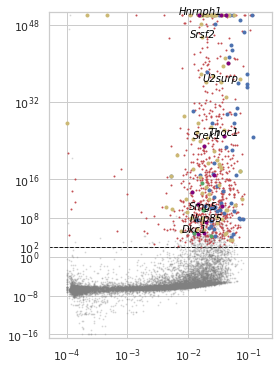

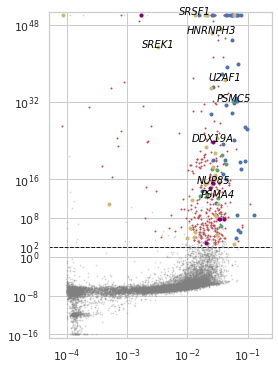

In [131]:
k_bound_lo = 1e-4 #1e-4 unit: min^-1: 1 per 7 days #same as in Bayes_factor_20220307.ipynb
N_range = 8 #same as in Bayes_factor_20220307.ipynb
x_range = [k_bound_lo*10**(i) for i in range(-1, N_range+1)]
y_range = np.asarray([1e-16, 1e-8, 1e0, 1e2, 1e8,1e16,1e32, 1e48])#[10**(i) for i in range(int(np.log10(eps)),20, 8)]#int(np.log10(cap))#[-16, -8, -4, -2, 0, 2, 4, 8, 16]]) ##the following is too large: does not work unfortunately: 32, 64]])
nd_cmap = ['b','g','y','purple']
visual_genes = dict()
visual_genes['m'] = {'Srsf2','U2surp','Srek1','Hnrnph1', 'Thoc1','Nup85', 'Dkc1', 'Smg5'}
visual_genes['h'] = {'SRSF1','U2AF1','SREK1','HNRNPH3', 'DDX19A','NUP85', 'PSMA4', 'PSMC5'}


for o in organisms:#[:1]:
    for ot in OUT_TYPES[:1]:
    
        x =  vc[o][ts+ot]
        y =  vc[o][bf]

        sns.set(style="whitegrid")
        fig, ax = plt.subplots(figsize=(4,6))#inches

        leg = ['','']#['nuclear degradation', 'other']
        g = plt.errorbar(x[vc[o]['nucdeg']], 
                         y[vc[o]['nucdeg']],
                     fmt="o",alpha=1,markersize=1,color='r',#MS figure: markersize=1
                     elinewidth=0.5)#size=1.5)
        

        plt.errorbar(x[~vc[o]['nucdeg']], 
                     y[~vc[o]['nucdeg']],
                     fmt="o",alpha=0.2,markersize=1,color='grey',
                     elinewidth=0.5)#size=1.5)
              
        for i, go_term in enumerate(nd_plot_GO[o]):        
            plt.errorbar(x[vc[o]['Gene'].isin(nd_plot_genes[o][go_term])], 
                         y[vc[o]['Gene'].isin(nd_plot_genes[o][go_term])],
                         fmt="o",alpha=1,markersize=3,color=nd_cmap[i],#(i),
                         elinewidth=0.5)#size=1.5)
            leg.append('')#'nuclear degradation: %s' % go_term)

        
        plt.plot(x_range, T_bf * np.ones(len(x_range)),'--k',linewidth=1)
        

#         if o == 'h':
            #add target names to plot
        for i in vc[o][vc[o]['Symbol'].isin(visual_genes[o])].index:
            gname = vc[o]['Symbol'][i]
            x_txt = x[i]
            y_txt = y[i]#+0.01
#             ax.annotate('figure pixels',
#             xy=(10, 10), xycoords='xydata')
            ax.text(x_txt, y_txt, gname, horizontalalignment='center', color='black', size=10,
                   weight='regular', fontstyle='italic')#'semibold',

    
        ax.set_xscale('log')
        ax.set_yscale('log')
        lim_min_x = 0.5 * max(min(x),1e-4) #min(min(x), min(y))
        lim_max_x = 2 * max(x)#max(max(x), max(y))
        lim_min_y = 0.2 * min(min(y),eps) #min(min(x), min(y))
        lim_max_y = 5 * max(max(y), cap)#max(max(x), max(y))
        plt.xticks(x_range)
        plt.yticks(y_range)
        plt.xlim(lim_min_x, lim_max_x)
        plt.ylim(lim_min_y, lim_max_y)

#         plt.xlabel(ts)
#         plt.ylabel(bf)

        filename = 'Nucdeg_xknucdeg'+ot+'_y'+bf+'_scat_'+o+'.'
#         plt.savefig(os.path.join(path,filename+'pdf'),bbox_inches="tight",transparent=True)
#         plt.savefig(os.path.join(path,filename+'tiff'),bbox_inches="tight",transparent=True,dpi=300)
#         plt.savefig(os.path.join(path,filename+'png'),bbox_inches="tight",transparent=True,dpi=300)

In [1]:
!pip freeze

asteval==0.9.23
attrs==19.3.0
backcall==0.1.0
backports.zoneinfo==0.2.1
bleach==3.1.4
certifi==2021.5.30
cffi==1.15.0
charset-normalizer==2.0.1
cycler==0.10.0
decorator==4.4.2
defusedxml==0.6.0
docopt==0.6.2
entrypoints==0.3
future==0.18.2
goatools==1.1.6
gtfparse==1.2.1
idna==3.2
importlib-metadata==1.5.2
ipykernel==5.2.0
ipython==7.13.0
ipython-genutils==0.2.0
ipywidgets==7.5.1
jedi==0.16.0
Jinja2==2.11.1
joblib==1.1.0
jsonschema==3.2.0
jupyter==1.0.0
jupyter-client==6.1.2
jupyter-console==6.1.0
jupyter-core==4.6.3
kiwisolver==1.1.0
llvmlite==0.36.0
lmfit==1.0.2
MarkupSafe==1.1.1
matplotlib==3.2.1
mistune==0.8.4
mpmath==1.2.1
nbconvert==5.6.1
nbformat==5.0.4
networkx==2.4
notebook==6.0.3
numba==0.53.1
numba-scipy==0.3.0
numpy==1.16.5
pandas==1.0.3
pandocfilters==1.4.2
parso==0.6.2
patsy==0.5.2
pexpect==4.8.0
pickleshare==0.7.5
Pillow==7.0.0
prometheus-client==0.7.1
prompt-toolkit==3.0.4
ptyprocess==0.6.0
pycparser==2.21
pydot==1.4.2
Pygments==2.6.1
pyparsing==2.4.6
pyrsistent==0.16.0

In [7]:
%%R 
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /n/app/openblas/0.2.19/lib/libopenblas_core2p-r0.2.19.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] tools     stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
[1] RColorBrewer_1.1-3 ggplot2_3.3.5      pheatmap_1.0.12   

loaded via a namespace (and not attached):
 [1] fansi_1.0.3      withr_2.5.0      utf8_1.2.2       crayon_1.5.1    
 [5] grid_4.1.1       R6_2.5.1         lifecycle_1.0.1  gtable_0.3.0    
 [9] magrittr_2.0.3   scales_1.1.1     pillar_